# Final Project - Multivariate Chronic Kidney Disease Predictive API

<div style="padding:10px; border:1px solid #a2b8d7ff; background:#a2b8d7ff; border-radius:8px;">
 <!-- Logo -->
  <img src="../../mhedas_logo.png"
       alt="Master Health Data Science"
       style="display:block; margin:0 auto 10px auto; max-width:260px; width:100%; height:auto;" />

<strong>Group ID:</strong> A<br>
<strong>Group Members:</strong> Navdeep Kaur, Laia Fortuny Parull, Marco Russo, Yudi Wang Zhang, Raians Sprogis Marons, José Pablo Soriano Torres, and Christian Dorado Cerrato <br>
<strong>Subject:</strong> Scientific Programming<br>

</div>


### Description of the project 
The project uses the Chronic Kidney Disease (CKD) dataset to build a machine learning model that predicts whether a patient has CKD or not. The dataset contains clinical and laboratory features with missing values, which are cleaned and processed before training and evaluating the model. The final model is deployed as an API that takes patient data as input and returns a diagnostic prediction.

In [1]:
#Necessary imports, paths, and dataset for the project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import spearmanr, pearsonr, chi2_contingency, mannwhitneyu, spearmanr, kruskal
from scipy.stats.contingency import association 
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer, RobustScaler

plt.style.use("ggplot")
sns.set_context("notebook")
pd.set_option("display.max_columns", None)

DATA_PATH = Path("../../data/raw/chronic_kindey_disease.csv")

In [2]:
%matplotlib inline


#### **Step 1**: Data Loading and Understanding

In [3]:
#Define the path to the text file
path = "../../data/raw/chronic_kidney_disease_info.txt"

#Read and print the contents of the text file
with open(path, "r", encoding="utf-8") as f:
    text = f.read()

print(text)

% 1. Title: Early stage of Indians Chronic Kidney Disease(CKD)
%
% 2. Source Information:
%   (a) Source: 
			Dr.P.Soundarapandian.M.D.,D.M
			(Senior Consultant Nephrologist), 
			Apollo  Hospitals, 
			Managiri,
			Madurai Main Road, 
			Karaikudi,
			Tamilnadu,
			India.

%   (b) Creator: 
			L.Jerlin Rubini(Research Scholar)
			Alagappa University,
			EmailId   :jel.jerlin@gmail.com
			ContactNo :+91-9597231281

%   (c) Guided by: 
			Dr.P.Eswaran Assistant Professor,
			Department of Computer Science and Engineering,
			Alagappa University,
			Karaikudi,
			Tamilnadu,
			India.
			Emailid:eswaranperumal@gmail.com

%   (d) Date     : July 2015
%
% 3.Relevant Information:
			age		-	age	
			bp		-	blood pressure
			sg		-	specific gravity
			al		-   	albumin
			su		-	sugar
			rbc		-	red blood cells
			pc		-	pus cell
			pcc		-	pus cell clumps
			ba		-	bacteria
			bgr		-	blood glucose random
			bu		-	blood urea
			sc		-	serum creatinine
			sod		-	sodium
			pot		-	potassium
			hemo		-	hem

The text file contains information regarding the dataset. It explains what each column means, which values are allowed, how missing data is marked (“?”), and how many CKD vs non-CKD cases are included.


In [4]:
#Load the dataset into a pandas DataFrame
df = pd.read_csv(DATA_PATH, na_values="?", skipinitialspace=True)
df.shape, df.columns

((400, 25),
 Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
        'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
        'appet', 'pe', 'ane', 'status'],
       dtype='object'))

From df.shape = (400, 25), our dataset has 400 rows (instances) and 25 columns (that's 24 predictors + 1 target column status).

In [5]:
#Preview of the first 10 rows of the dataset
df.head(10)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,status
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,74.0,25.0,1.1,142.0,3.2,12.2,39.0,7800.0,4.4,yes,yes,no,good,yes,no,ckd
6,68.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,100.0,54.0,24.0,104.0,4.0,12.4,36.0,NaN,NaN,no,no,no,good,no,no,ckd
7,24.0,NaN,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.0,31.0,1.1,NaN,NaN,12.4,44.0,6900.0,5.0,no,yes,no,good,yes,no,ckd
8,52.0,100.0,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.0,60.0,1.9,NaN,NaN,10.8,33.0,9600.0,4.0,yes,yes,no,good,no,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd


In [6]:
#Get summary statistics of the DataFrame
df.describe() 

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


### Step 1.2: Initial Data Cleaning

In [7]:
#Check for unique values in categorical columns to spot dirty data
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

rbc: [nan 'normal' 'abnormal']
pc: ['normal' 'abnormal' nan]
pcc: ['notpresent' 'present' nan]
ba: ['notpresent' 'present' nan]
htn: ['yes' 'no' nan]
dm: ['yes' 'no' '\tno' nan]
cad: ['no' 'yes' nan]
appet: ['good' 'poor' nan]
pe: ['no' 'yes' nan]
ane: ['no' 'yes' nan]
status: ['ckd' 'ckd\t' 'notckd']


In [8]:
# Cleaning: Removing potential whitespace (e.g., '\tno', ' yes')
# We found specific issues in 'dm', 'cad', and 'status' columns
cols_to_clean = ['dm', 'status']

def clean_text(x):
    if isinstance(x, str):
        return x.strip().lower()
    return x

for col in cols_to_clean:
    df[col] = df[col].apply(clean_text)

# Verify Cleaning
print("\nPost-Cleaning Unique Values")
print(f"Status: {df['status'].unique()}")


Post-Cleaning Unique Values
Status: ['ckd' 'notckd']


### **Step 1.3: Distribution of the features**

#### **Step 1.3.1 Distribution of the numeric variables**

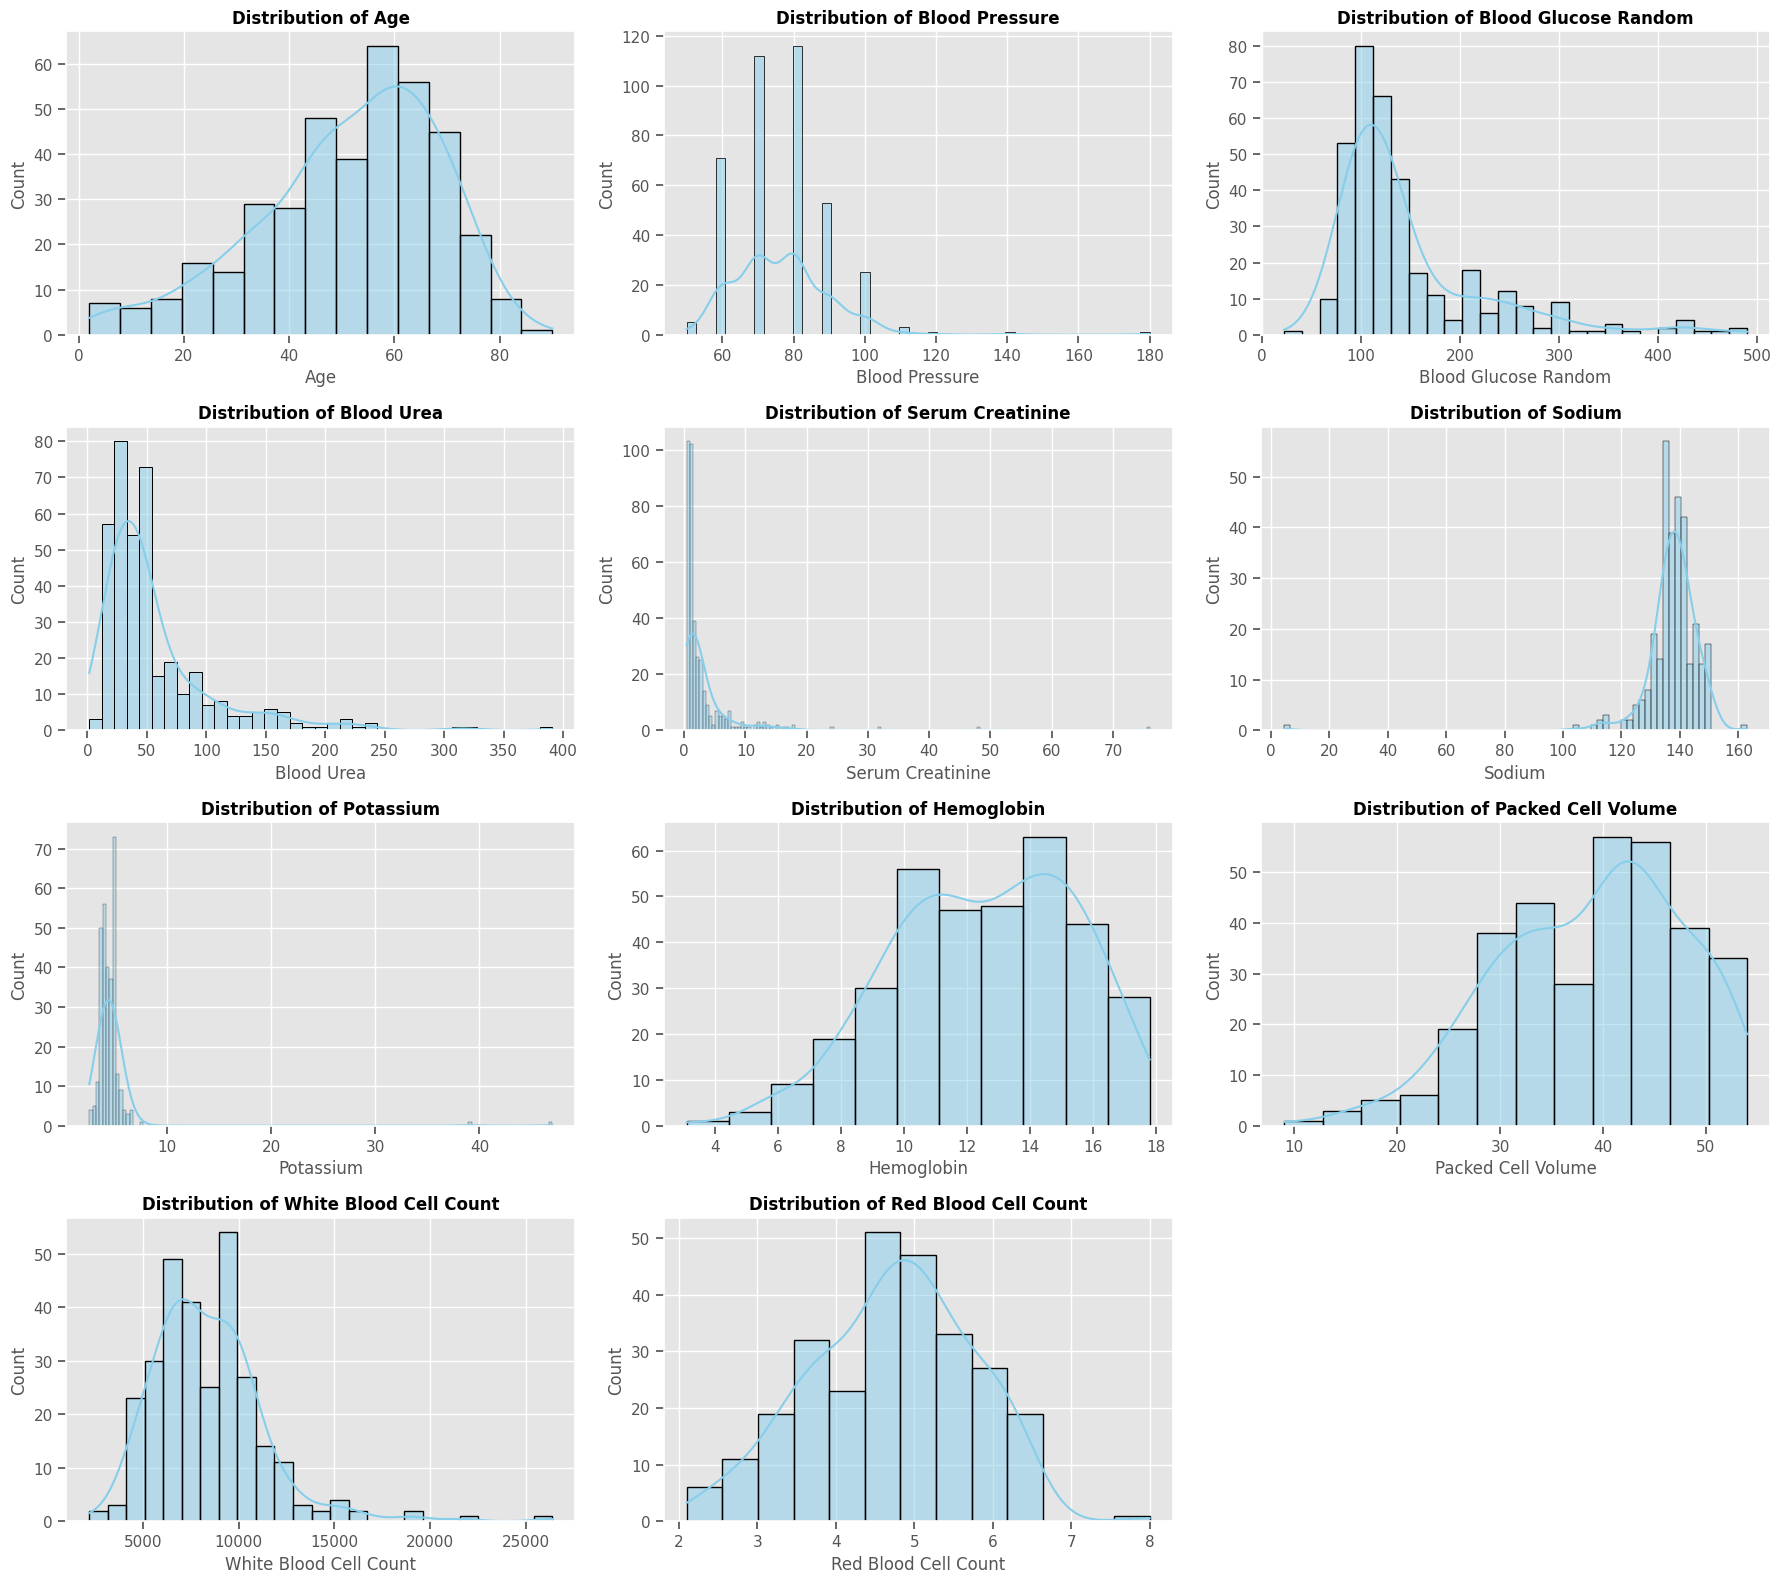

In [9]:
# Dictionary mapping column names to full names based on dataset documentation
numeric_cols_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count'
}

# Setup the plotting grid (4 rows x 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (col, full_name) in enumerate(numeric_cols_mapping.items()):
    # Plot histogram with KDE
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], color='skyblue', edgecolor='black') # type: ignore

    # Set titles and labels using the full name
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(len(numeric_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **Step 1.3.2 Distribution of the categorical variables**

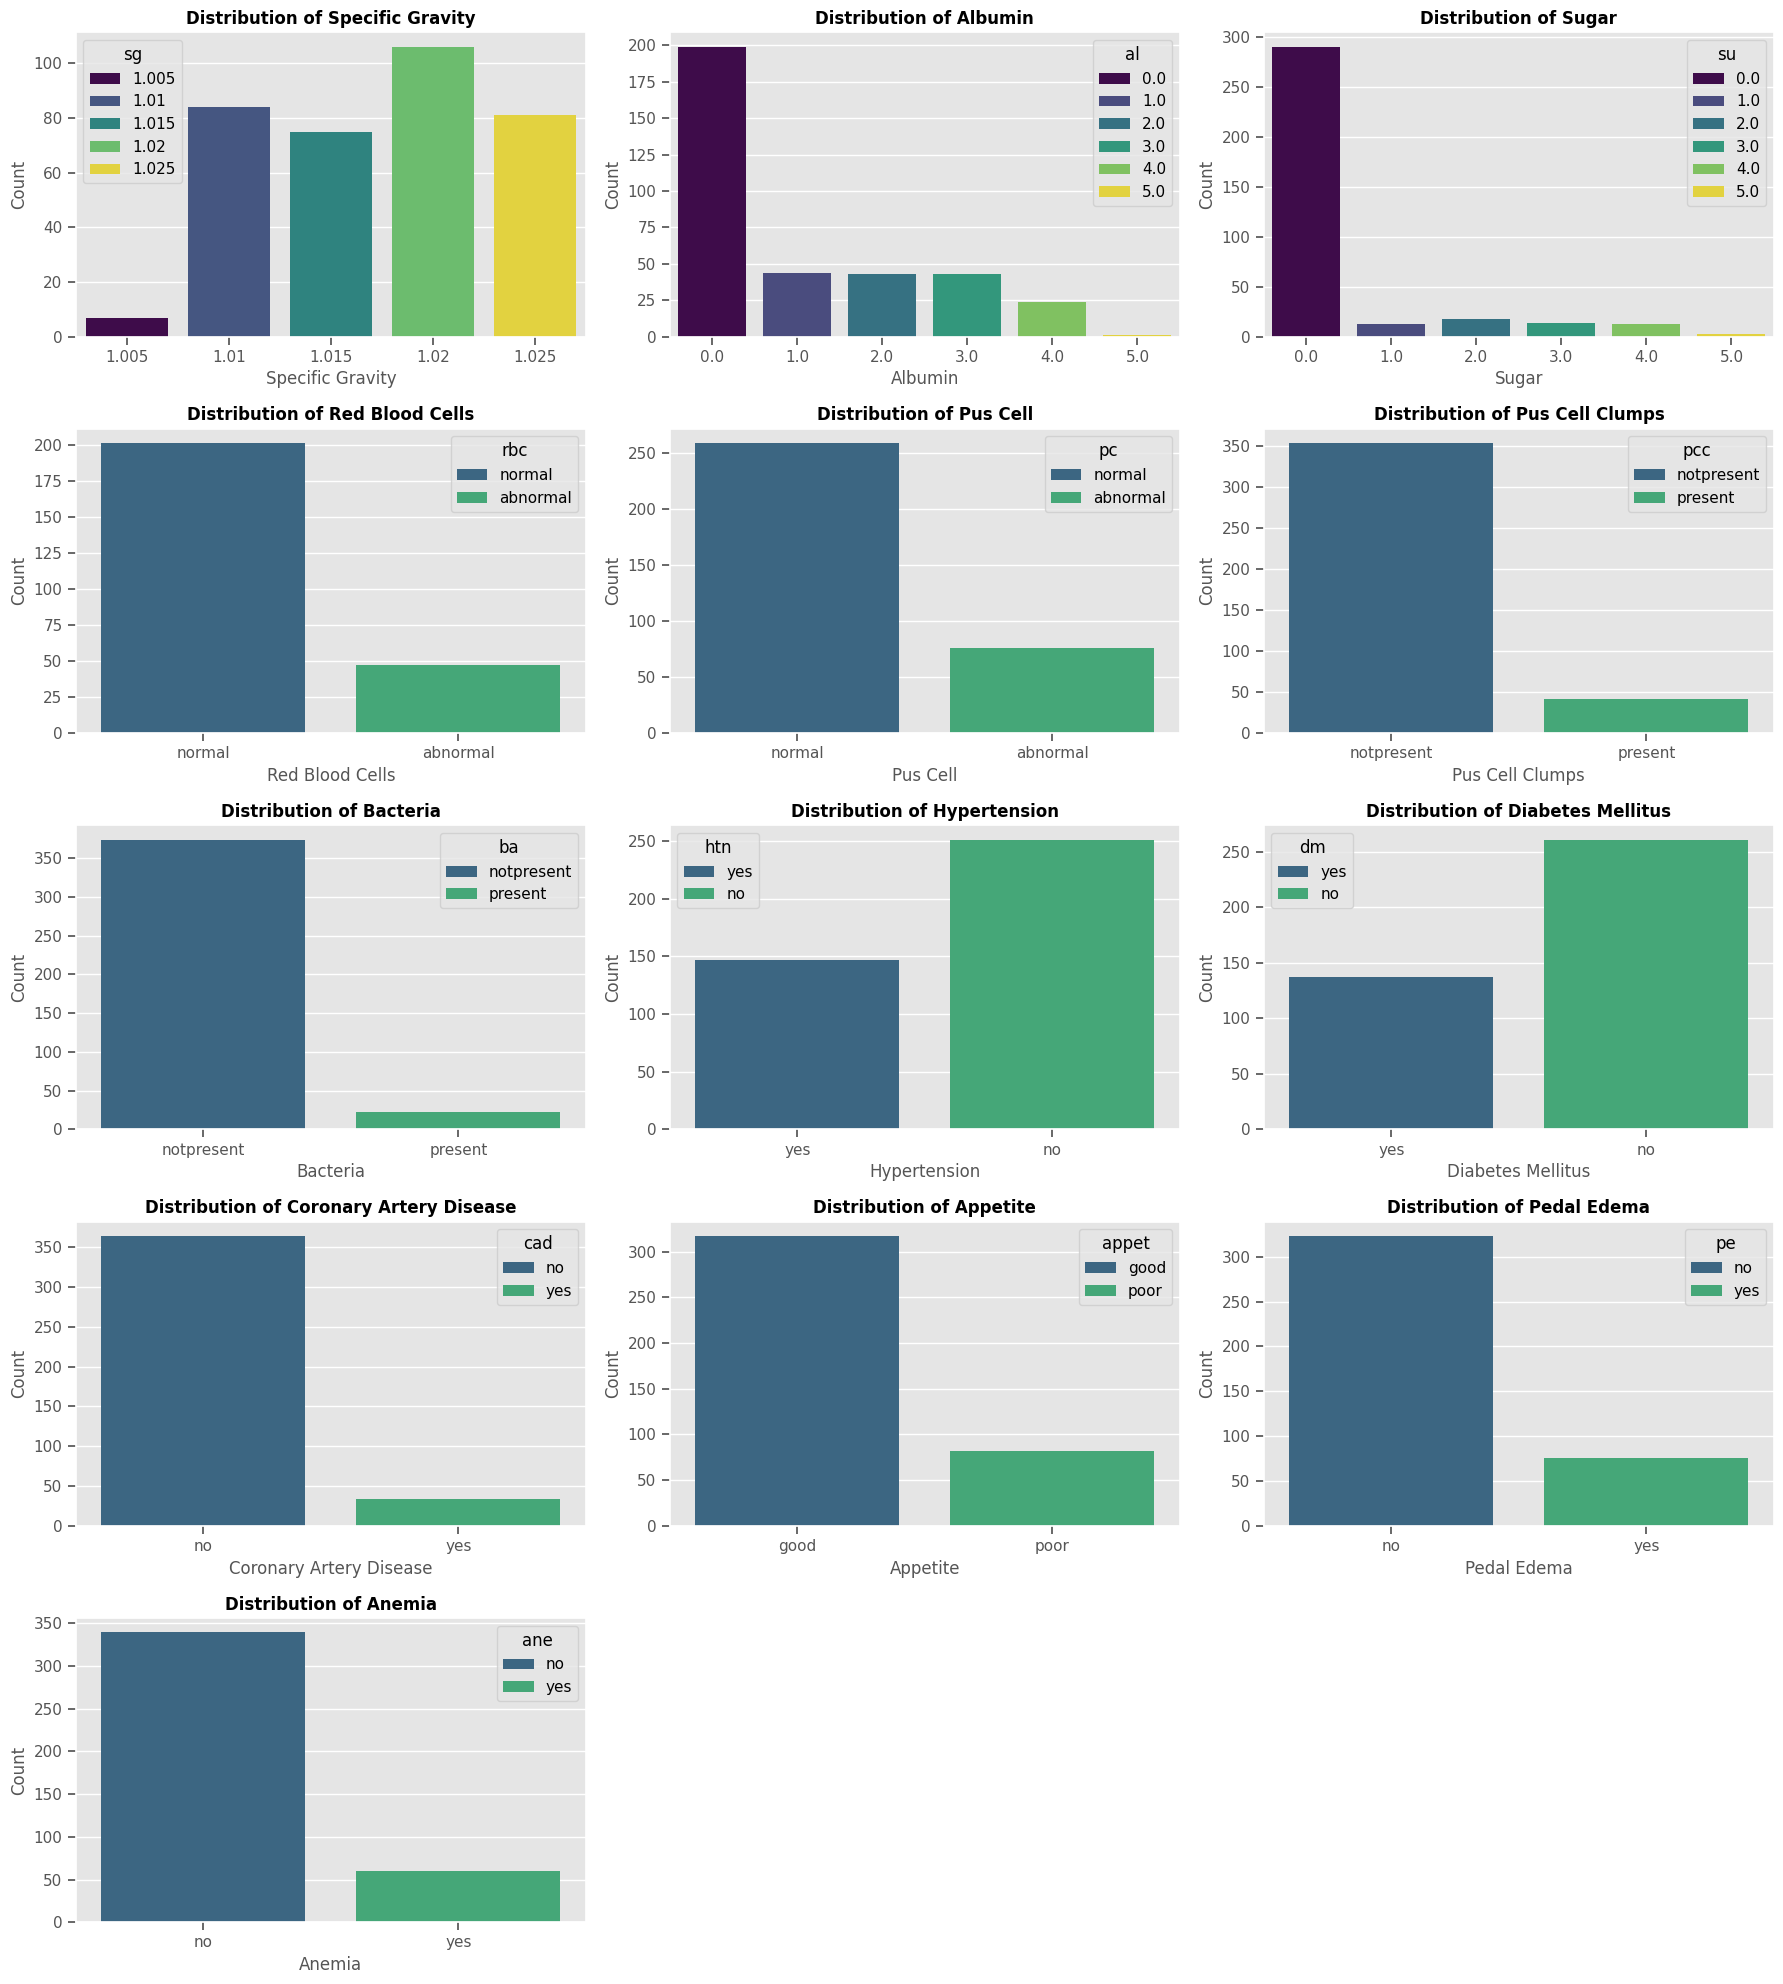

In [10]:
#Dictionary mapping categorical columns to full names
categorical_cols_mapping = {
    'sg': 'Specific Gravity',
    'al': 'Albumin',
    'su': 'Sugar',
    'rbc': 'Red Blood Cells',
    'pc': 'Pus Cell',
    'pcc': 'Pus Cell Clumps',
    'ba': 'Bacteria',
    'htn': 'Hypertension',
    'dm': 'Diabetes Mellitus',
    'cad': 'Coronary Artery Disease',
    'appet': 'Appetite',
    'pe': 'Pedal Edema',
    'ane': 'Anemia'
}

# Setup the plotting grid (5 rows x 3 columns)
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

for i, (col, full_name) in enumerate(categorical_cols_mapping.items()):
    # Sort order for ordinal variables (sg, al, su) to make the plot logical
    order = sorted(df[col].dropna().unique()) if col in ['sg', 'al', 'su'] else None

    # Create Count Plot
    sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', order=order, hue= col)

    # Styling
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove empty subplots
for j in range(len(categorical_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **Step 1.3.3: Distribution of the Class**

status
ckd       250
notckd    150
Name: count, dtype: int64


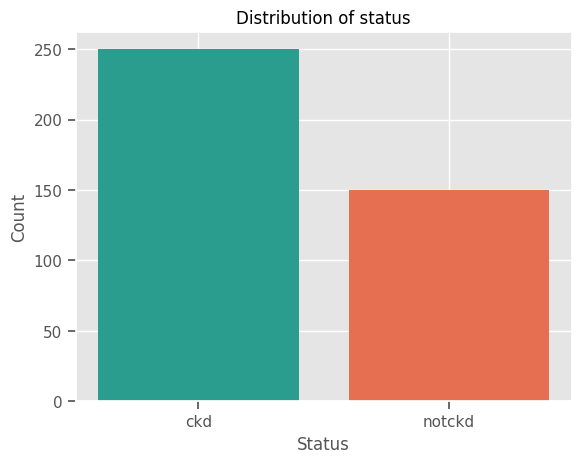

In [11]:
#Visualize the distribution of the "status" column

df["status"] = df["status"].astype(str).str.strip()
counts = df["status"].value_counts()
print(counts)
counts = counts.reindex(["ckd", "notckd"])  # consistent order
colors = ["#2a9d8f", "#e76f51"]  # teal + coral

plt.figure()
plt.bar(counts.index, counts, color=colors)
plt.xlabel("Status")
plt.ylabel("Count")
plt.title("Distribution of status")
plt.show()



Out of 400 individuals, 250 (62.5%) are labeled ckd and 150 (37.5%) are labeled notckd. We can consider the class distribution to be moderately imbalanced

### **Step 2: Data Preparation**

#### **Step 2.1:Missing Value Analysis**

In [12]:
df.isna().sum()

age         9
bp         12
sg         47
al         46
su         49
rbc       152
pc         65
pcc         4
ba          4
bgr        44
bu         19
sc         17
sod        87
pot        88
hemo       52
pcv        71
wbcc      106
rbcc      131
htn         2
dm          2
cad         2
appet       1
pe          1
ane         1
status      0
dtype: int64

We have 1012 missing values in total. Missingness affects 14 numeric and 10 categorical variables. Among the numeric features, the highest missing counts occur in 
- **red blood cell count (rbcc, 131)** 
- **white blood cell count (wbcc, 106)**
- **potassium (pot, 88)**
- **sodium (sod, 87)**
- **packed cell volume (pcv, 71)**
- **hemoglobin (hemo, 52)**
- **albumin (al, 46)**
- **random blood glucose (bgr, 44)**
- **blood urea (bu, 19)**
- **serum creatinine (sc, 17)**
- **blood pressure (bp, 12)**
- **age (age, 9)**

For categorical variables, missingness is mainly concentrated in 
- **red blood cells (rbc, 152)**
- **sugar (su, 49)**
- **specific gravity (sg, 47)**
- **pus cell (pc, 65)**
- **pus cell clumps (pcc, 4)**
- **bacteria (ba, 4)**
- **hypertension (htn, 2)**
- **diabetes mellitus (dm, 2)**
- **coronary artery disease (cad, 2)**
- **appetite (appet, 1)**
- **pedal edema (pe, 1)**
- **anemia (ane, 1)**.


In [13]:
#Overall missing values summary
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_rates = (df.isna().mean() * 100).sort_values(ascending=False)

summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_%": missing_rates.round(2)
})

summary = summary[summary["missing_count"] > 0]
summary.head(20)


,missing_count,missing_%
rbc,152,38.00
rbcc,131,32.75
wbcc,106,26.50
pot,88,22.00
sod,87,21.75
pcv,71,17.75
pc,65,16.25
hemo,52,13.00
su,49,12.25
sg,47,11.75


#### **Step 2.1.1: Check if missingness is predictive**

For each feature, we tested whether being missing is associated with the class (CKD vs not CKD).

In [14]:
#Missingness by status (CKD vs notCKD): This tells us if a column is missing more in one class than the other.
# Missing % per column within each class
miss_by_class = (
    df.isna()
    .groupby(df["status"])
    .mean()
    .T * 100
)

# Keep only columns that have any missing values
miss_by_class = miss_by_class.loc[summary.index]

# Add a "gap" column (absolute difference between classes)
# (works even if order is not exactly ckd/notckd)
cols = miss_by_class.columns.tolist()
if len(cols) == 2:
    miss_by_class["gap_%"] = (miss_by_class[cols[0]] - miss_by_class[cols[1]]).abs()

miss_by_class.sort_values("gap_%" if "gap_%" in miss_by_class.columns else cols[0], ascending=False).head(20)


status,ckd,notckd,gap_%
rbc,57.2,6.000000,51.200000
rbcc,49.6,4.666667,44.933333
wbcc,39.6,4.666667,34.933333
pot,33.2,3.333333,29.866667
sod,32.8,3.333333,29.466667
pcv,26.8,2.666667,24.133333
pc,22.4,6.000000,16.400000
hemo,18.4,4.000000,14.400000
su,17.6,3.333333,14.266667
sg,16.8,3.333333,13.466667


From the previous table we can infer that missingness is not random. It is systematically higher in the CKD group for many variables. 

#### **Step 2.1.2: Choose an imputation strategy**

Imputation is the process of replacing missing entries (NaNs) with acceptable values so the dataset can be used for downstream analysis and modeling. Instead of deleting incomplete rows (which can shrink the dataset and introduce bias) we estimate missing values using other variables. The key idea is that missing data is rarely random in clinical datasets, many variables are clinically connected (e.g., hemoglobin and anemia). Therefore, we chose imputation strategies that respect medical relationships and preserve realistic combinations of values.




Before imputing we will examine the clinical structure of features.

1) **The Anemia Profile**: We will first study the anemia profile. Anemia is not an isolated label, it's supported by multiple blood measurements. So for this categorical variable we will take into account the following numerical features that are biologically linked and jointly reflect oxygen-carrying capacity:
- Hemoglobin (hemo)
- Packed Cell Volume (pcv)
- Red Blood Cell Count (rbcc)



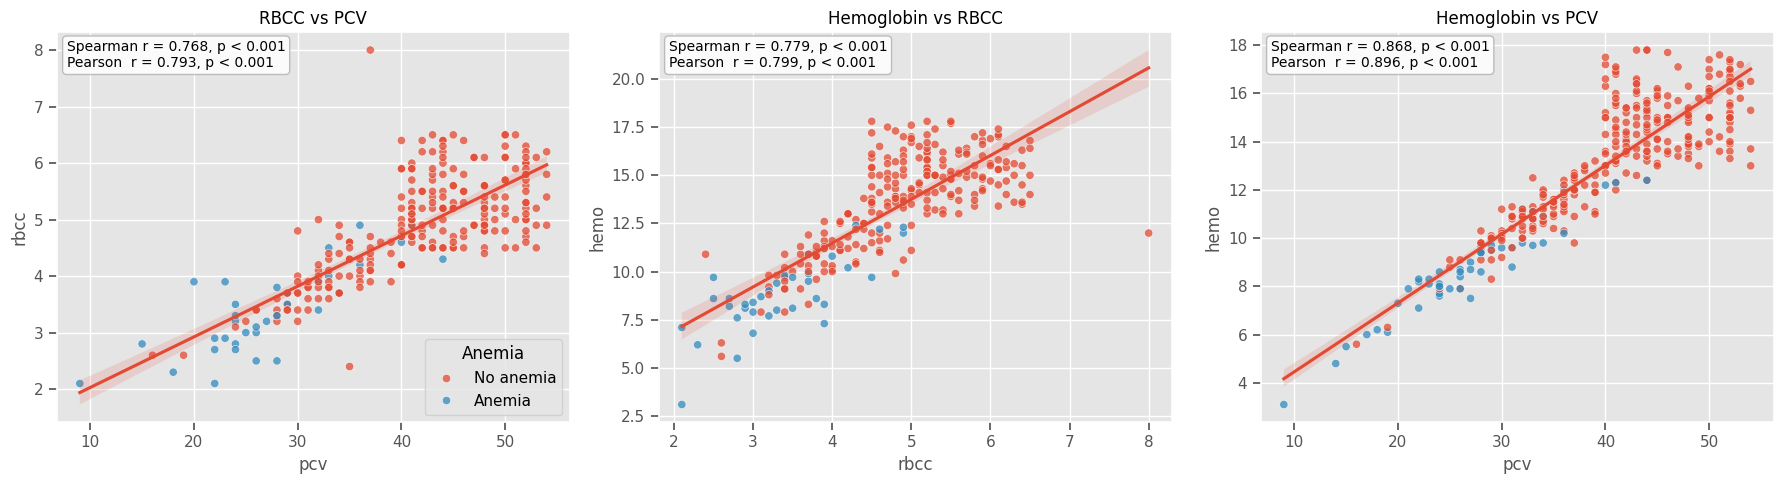

In [15]:
#Format p-values for plot text (Spearman/Pearson annotations)
def fmt_p(p): 
    return "< 0.001" if p < 1e-3 else f"= {p:.3f}"

#Clean anemia label + numeric lab values in one expression
ane = (
    df.assign(
        ane=df["ane"].astype("string").str.strip().str.lower(),
        ane_lbl=lambda d: d["ane"].replace({"yes": "Anemia", "no": "No anemia"})
    )
    .assign(**{c: pd.to_numeric(df[c], errors="coerce") for c in ["hemo","pcv","rbcc"]})
    .loc[lambda d: d["ane_lbl"].isin(["Anemia","No anemia"])]
)

#(x, y, title) to plot
pairs = [
    ("pcv","rbcc","RBCC vs PCV"),
    ("rbcc","hemo","Hemoglobin vs RBCC"),
    ("pcv","hemo","Hemoglobin vs PCV"),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (x, y, title), show_leg in zip(axes, pairs, [True, False, False]):
    # Scatter with anemia hue, regression overlay for overall trend
    sns.scatterplot(ane, x=x, y=y, hue="ane_lbl", alpha=0.75, ax=ax, legend=show_leg)
    sns.regplot(ane, x=x, y=y, scatter=False, ax=ax)

    # Compute correlations on valid pairs only
    tmp = ane[[x, y]].dropna()
    stats = "\n".join([
        f"Spearman r = {spearmanr(tmp[x], tmp[y]).correlation:.3f}, p {fmt_p(spearmanr(tmp[x], tmp[y]).pvalue)}",
        f"Pearson  r = {pearsonr(tmp[x], tmp[y])[0]:.3f}, p {fmt_p(pearsonr(tmp[x], tmp[y])[1])}",
    ])

    #Annotate subplot with correlation values
    ax.text(
        0.02, 0.98, stats,
        transform=ax.transAxes, va="top", ha="left",
        fontsize=10, bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="0.7")
    )
    ax.set(title=title, xlabel=x, ylabel=y)

#Keep a single legend on the first subplot
if axes[0].legend_:
    axes[0].legend(title="Anemia", loc="lower right", frameon=True)

plt.tight_layout()
plt.show()



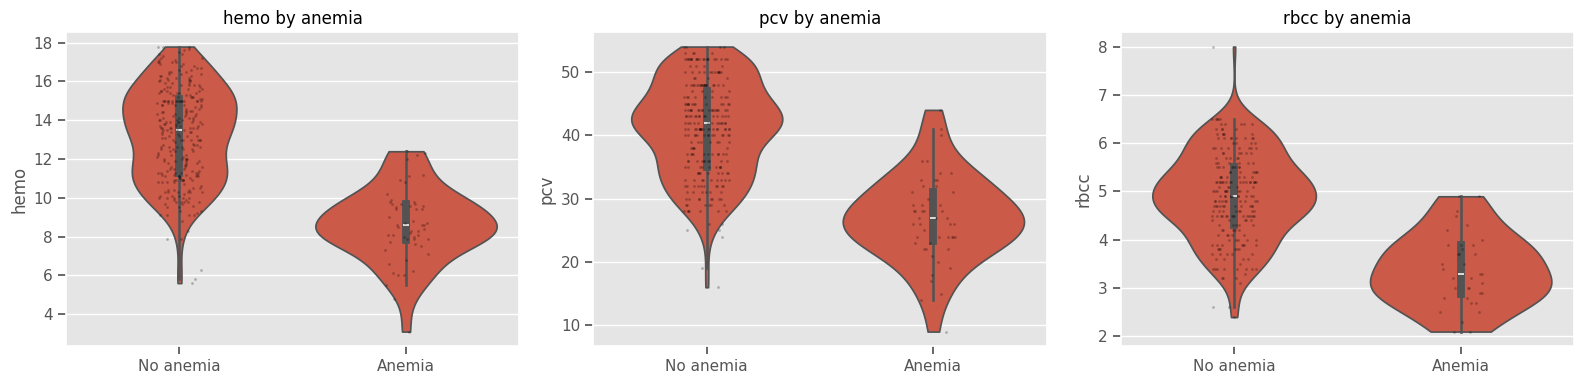

In [16]:
#Do the distributions differ between Anemia vs No anemia?” (numeric vs categorical)
#The violin shaped comes in handy to see the distribution's difference
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, x in zip(axes, ["hemo", "pcv", "rbcc"]):
    sns.violinplot(data=ane, x="ane_lbl", y=x, ax=ax, inner="box", cut=0)
    sns.stripplot(data=ane, x="ane_lbl", y=x, ax=ax, color="black", alpha=0.25, size=2)
    ax.set_title(f"{x} by anemia")
    ax.set_xlabel("")
    ax.set_ylabel(x)

plt.tight_layout()
plt.show()


**Conclusion for Anemia Profile**: 

The anemia-related numeric markers were strongly positively associated with each other. 
- PCV correlated strongly with hemoglobin (Pearson r = 0.896; Spearman r = 0.868; p < 0.001)
- RBCC also showed positive correlations with PCV (Pearson r = 0.793; Spearman r = 0.768; p < 0.001) and hemoglobin (Pearson r = 0.799; Spearman r = 0.779; p < 0.001). 

When we split the data by anemia status, hemoglobin, PCV, and RBCC are all clearly lower in the anemia group than in the no-anemia group.


2) **The Diabetes and Glucose Profile**

This profile is useful because if one glucose-related variable is missing, the others might help us estimate it. In this profile, we consider:

- Blood Glucose Random (bgr): a numeric blood measurement of glucose
- Sugar (su): an ordinal urine sugar scale (0-5)
- Diabetes Mellitus (dm): a categorical indicator of diabetes status

These three variables are clinically linked, bgr measures glucose directly, su reflects glucose spilling into urine, and both are expected to align with dm.


Rows used (complete for bgr+su+dm): 311

Chi-square: su vs dm
chi2=99.016, dof=5, p=8.520e-20, Cramer's V=0.564

Mann-Whitney U: bgr (dm=yes) vs bgr (dm=no)
U=17542.0, p=1.838e-22, rank-biserial=-0.690
median bgr dm=yes: 208.0 | dm=no: 109.0


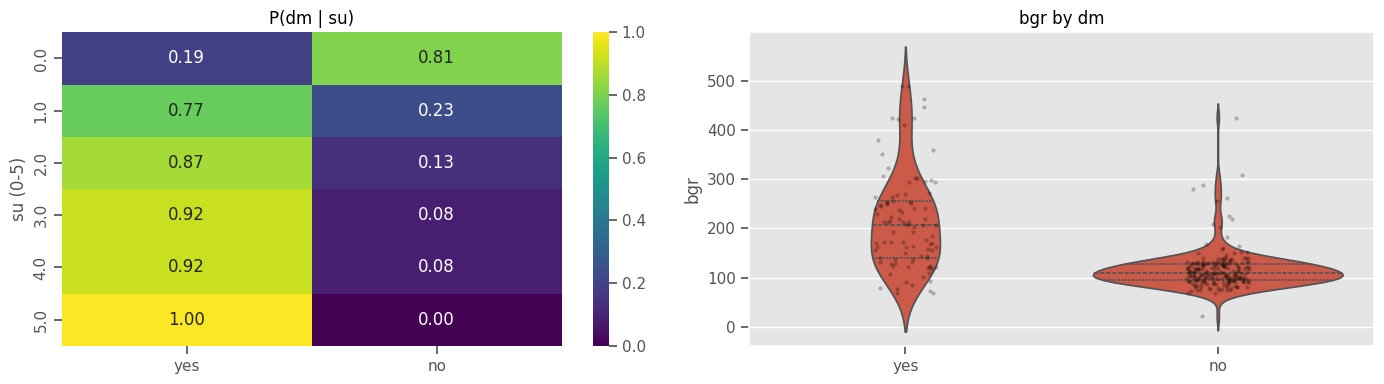


Spearman: su vs bgr
rho=0.603, p=3.474e-32


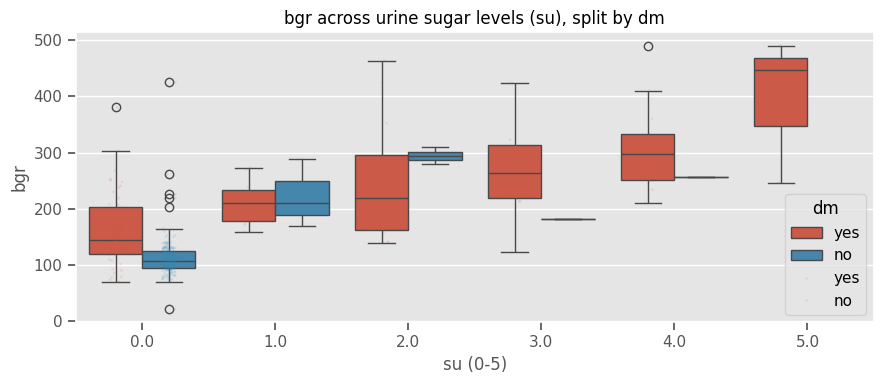

In [17]:
diab = df.copy() #we'll work with a copy of the original dataset

#Convert glucose-related variables to numeric
# su is urine sugar level (should be 0–5), bgr is blood glucose random (numeric)
diab["su"] = pd.to_numeric(diab["su"], errors="coerce")
diab["bgr"] = pd.to_numeric(diab["bgr"], errors="coerce")

# If su is not in [0,5], set to NaN
diab.loc[~diab["su"].between(0, 5), "su"] = np.nan
#if dm is not yes or no, set to NaN
diab.loc[~diab["dm"].isin(["yes", "no"]), "dm"] = np.nan

d = diab[["bgr", "su", "dm"]].dropna()
print(f"Rows used (complete for bgr+su+dm): {len(d)}")

#Helper functions for statistics
def cramers_v(ct):
    """
    Cramér's V effect size for association between two categorical variables.
    su (0-5) vs dm (yes/no), using a contingency table.
    """
    chi2, p, dof, _ = chi2_contingency(ct)
    n = ct.to_numpy().sum()
    denom = min(ct.shape[0]-1, ct.shape[1]-1)
    return chi2, p, dof, np.sqrt((chi2 / n) / denom) if denom > 0 else np.nan

def mwu_with_effect(x_yes, x_no):
    """
    Mann-Whitney U test for numeric variable split by two groups.
    Also returns rank-biserial correlation as an effect size.
    bgr in dm=yes vs dm=no.
    """
    U, p = mannwhitneyu(x_yes, x_no, alternative="two-sided")
    rbc = 1 - (2 * U) / (len(x_yes) * len(x_no))
    return U, p, rbc

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# su <-> dm (categorical association)
ct = pd.crosstab(d["su"], d["dm"])
prop = ct.div(ct.sum(axis=1), axis=0)
sns.heatmap(prop[["yes", "no"]], annot=True, fmt=".2f", cmap="viridis", ax=axes[0])
axes[0].set(title="P(dm | su)", xlabel="", ylabel="su (0-5)")
chi2, p, dof, v = cramers_v(ct)
print(f"\nChi-square: su vs dm\nchi2={chi2:.3f}, dof={dof}, p={p:.3e}, Cramer's V={v:.3f}")

#bgr <-> dm (numeric vs binary)
sns.violinplot(data=d, x="dm", y="bgr", inner="quartile", ax=axes[1])
sns.stripplot(data=d, x="dm", y="bgr", color="k", alpha=0.25, size=3, ax=axes[1])
axes[1].set(title="bgr by dm", xlabel="")
bgr_yes, bgr_no = d.loc[d["dm"] == "yes", "bgr"], d.loc[d["dm"] == "no", "bgr"]
U, p_mwu, rbc = mwu_with_effect(bgr_yes, bgr_no)
print(f"\nMann-Whitney U: bgr (dm=yes) vs bgr (dm=no)\nU={U:.1f}, p={p_mwu:.3e}, rank-biserial={rbc:.3f}")
print(f"median bgr dm=yes: {np.median(bgr_yes):.1f} | dm=no: {np.median(bgr_no):.1f}")
plt.tight_layout()
plt.show()

#bgr <-> su (numeric vs ordinal trend)
rho, p_s = spearmanr(d["su"], d["bgr"])
print(f"\nSpearman: su vs bgr\nrho={rho:.3f}, p={p_s:.3e}")
plt.figure(figsize=(9, 4))
sns.boxplot(data=d, x="su", y="bgr", hue="dm")
sns.stripplot(data=d, x="su", y="bgr", hue="dm", dodge=True, alpha=0.12, size=2)
plt.title("bgr across urine sugar levels (su), split by dm")
plt.xlabel("su (0-5)")
plt.tight_layout()
plt.show()


**Conclusion for the Diabetes and Glucose Profile:**

Diabetics had substantially higher bgr than non-diabetics (median 208 vs 109; Mann–Whitney U=17542.0, p=1.838×10⁻²²; rank-biserial=0.690). Urine sugar and blood glucose showed a strong positive association (Spearman ρ=0.603, p=3.474×10⁻³²). Urine sugar level was strongly associated with diabetes status (χ²=99.016, df=5, p=8.520×10⁻²⁰; Cramér’s V=0.564), supporting a coherent diabetes-glucose profile in the dataset.

3) **Hypertension and Cardiovascular Profile**

Blood pressure (bp) is a key numeric marker that aligns with cardiovascular comorbidities. In the dataset, we want to see whether higher bp values frequently co-occur with htn = “yes”, and cad tends to follow related cardiovascular patterns. 



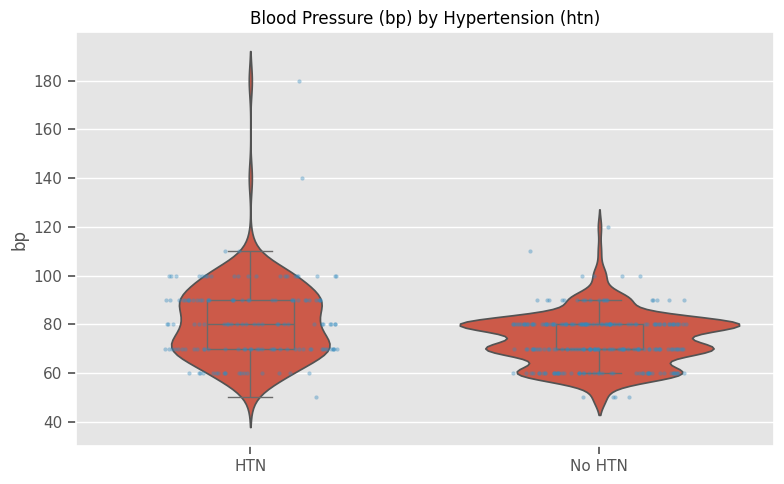

MWU bp by htn (No HTN vs HTN): U=12507.5, p=1.416e-06, rank-biserial=0.284 | n(no)=241, n(yes)=145
median bp No HTN: 70.0 | HTN: 80.0


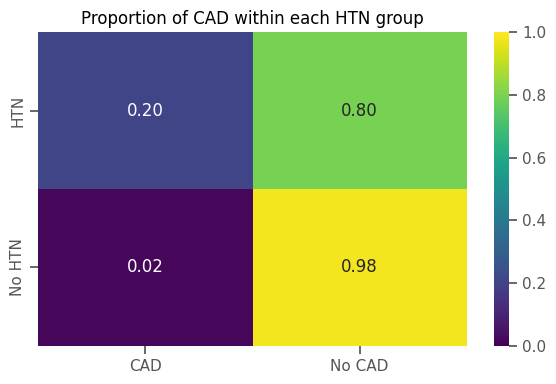


Counts CAD vs HTN:
cad_lbl  CAD  No CAD
htn_lbl             
HTN       30     117
No HTN     4     247

Chi-square test (htn vs cad): chi2=39.629, dof=1, p=3.070e-10, Cramer's V=0.325


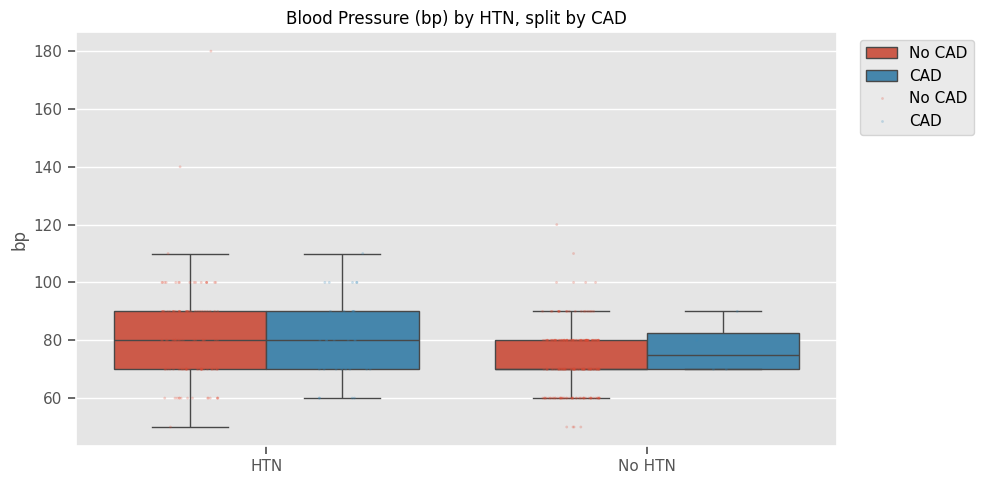

In [18]:

# Hypertension + Cardiovascular profile (bp <-> htn <-> cad) 

#We will work with a copy of the original dataset 
df_h = df.copy(deep=True)

#Ensure bp numeric
df_h["bp"] = pd.to_numeric(df_h["bp"], errors="coerce")

#Clean categorical strings
for c in ["htn", "cad", "status"]:
    if c in df_h.columns:
        df_h[c] = df_h[c].astype("string").str.strip().str.lower()

#Create nice labels
df_h["htn_lbl"] = df_h["htn"].map({"yes": "HTN", "no": "No HTN"})
df_h["cad_lbl"] = df_h["cad"].map({"yes": "CAD", "no": "No CAD"})

#Drop rows where we cannot evaluate (bp or htn missing)
df_bp_htn = df_h.dropna(subset=["bp", "htn_lbl"]).copy()

#VISUAL 1: BP distribution by HTN (violin/box)
plt.figure(figsize=(8,5))
sns.violinplot(data=df_bp_htn, x="htn_lbl", y="bp", inner=None)
sns.stripplot(data=df_bp_htn, x="htn_lbl", y="bp", alpha=0.4, jitter=0.25, size=3)
sns.boxplot(data=df_bp_htn, x="htn_lbl", y="bp", width=0.25, showcaps=True,
            boxprops={'facecolor':'none'}, showfliers=False)
plt.title("Blood Pressure (bp) by Hypertension (htn)")
plt.xlabel("")
plt.ylabel("bp")
plt.tight_layout()
plt.show()

#STAT TEST: BP differs by HTN? (Mann–Whitney U)
bp_no = df_bp_htn.loc[df_bp_htn["htn_lbl"]=="No HTN", "bp"].dropna()
bp_yes = df_bp_htn.loc[df_bp_htn["htn_lbl"]=="HTN", "bp"].dropna()
U, p = mannwhitneyu(bp_no, bp_yes, alternative="two-sided")
#Rank-biserial (direction depends on ordering)
n1, n2 = len(bp_no), len(bp_yes)
rbc = 1 - (2*U)/(n1*n2)
print(f"MWU bp by htn (No HTN vs HTN): U={U:.1f}, p={p:.3e}, rank-biserial={rbc:.3f} | n(no)={n1}, n(yes)={n2}")
print(f"median bp No HTN: {np.median(bp_no):.1f} | HTN: {np.median(bp_yes):.1f}")


#VISUAL 2: CAD prevalence within HTN groups (proportions heatmap)
df_htn_cad = df_h.dropna(subset=["htn_lbl", "cad_lbl"]).copy()
ct = pd.crosstab(df_htn_cad["htn_lbl"], df_htn_cad["cad_lbl"])
prop = ct.div(ct.sum(axis=1), axis=0)
#plot
plt.figure(figsize=(6,4))
sns.heatmap(prop, annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1)
plt.title("Proportion of CAD within each HTN group")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()
print("\nCounts CAD vs HTN:")
print(ct)

#STAT TEST: CAD associated with HTN? (Chi-square + Cramer's V)
chi2, p_chi, dof, exp = chi2_contingency(ct)
cramers_v = association(ct, method="cramer")
print(f"\nChi-square test (htn vs cad): chi2={chi2:.3f}, dof={dof}, p={p_chi:.3e}, Cramer's V={cramers_v:.3f}")

# VISUAL 3: BP distribution split by BOTH HTN and CAD
# This visualization will help show whether higher bp often coincides with yes htn and yes cad')
df_bp_two = df_h.dropna(subset=["bp","htn_lbl","cad_lbl"]).copy()
plt.figure(figsize=(10,5))
sns.boxplot(data=df_bp_two, x="htn_lbl", y="bp", hue="cad_lbl", showfliers=False)
sns.stripplot(data=df_bp_two, x="htn_lbl", y="bp", hue="cad_lbl",
              dodge=True, alpha=0.25, size=2, jitter=0.15)
plt.title("Blood Pressure (bp) by HTN, split by CAD")
plt.xlabel("")
plt.ylabel("bp")
plt.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [19]:
#Calculation of Odds Ratio 

# ct should be a 2x2 table with rows=HTN group, cols=CAD group
# From our counts we obtains the following 2x2 contigency table
#           CAD  No CAD
# HTN        30    117
# No HTN      4    247

a, b = 30, 117   # HTN: CAD / No CAD
c, d = 4,  247   # No HTN: CAD / No CAD
OR = (a*d) / (b*c)
# 95% CI for log(OR)
se = np.sqrt(1/a + 1/b + 1/c + 1/d)
ci_low = np.exp(np.log(OR) - 1.96*se)
ci_high = np.exp(np.log(OR) + 1.96*se)
print(f"Odds Ratio (CAD | HTN vs No HTN) = {OR:.2f} (95% CI {ci_low:.2f} to {ci_high:.2f})")


Odds Ratio (CAD | HTN vs No HTN) = 15.83 (95% CI 5.45 to 45.99)


**Conclusions for the Hypertension and Cardiovascular Profile**:

- People labeled HTN have higher blood pressure than those labeled No HTN based based on the **“bp by htn” violin/strip plot**, where the HTN group is shifted upward(median 80 vs 70; p = 1.416e-06).
- CAD is much more common in HTN than in No HTN (~20% vs ~1.6%; p = 3.07e-10; moderate association).
- The plot of bp by HTN split by CAD (hue) supports the interpretation that BP differences mainly track HTN, while CAD is mostly concentrated within the HTN group. 
- Odds ratio: HTN is strongly associated with CAD: HTN patients have ~15.83× higher odds of CAD (95% CI 5.45–45.99)

4) **The Urinalysis Profile**

Urine findings linked to infection/inflammation and kidney damage often appear together rather than independently. In this profile we include specific gravity (sg) and albumin (al) (ordinal measures), along with categorical indicators such as red blood cells (rbc), pus cells (pc), pus cell clumps (pcc), and bacteria (ba). Based on clinical knowledge, we expect patterns like abnormal rbc/pc to coincide with higher albumin and potentially lower specific gravity, reflecting renal injury or inflammatory processes.

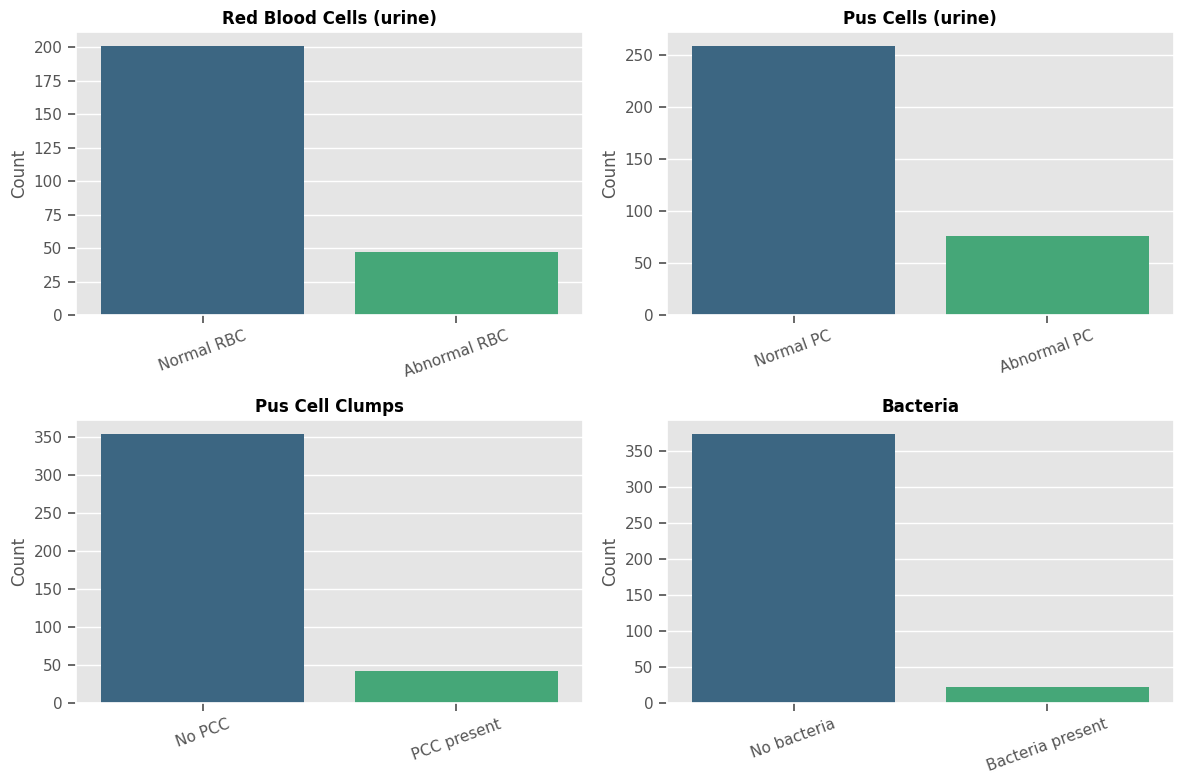

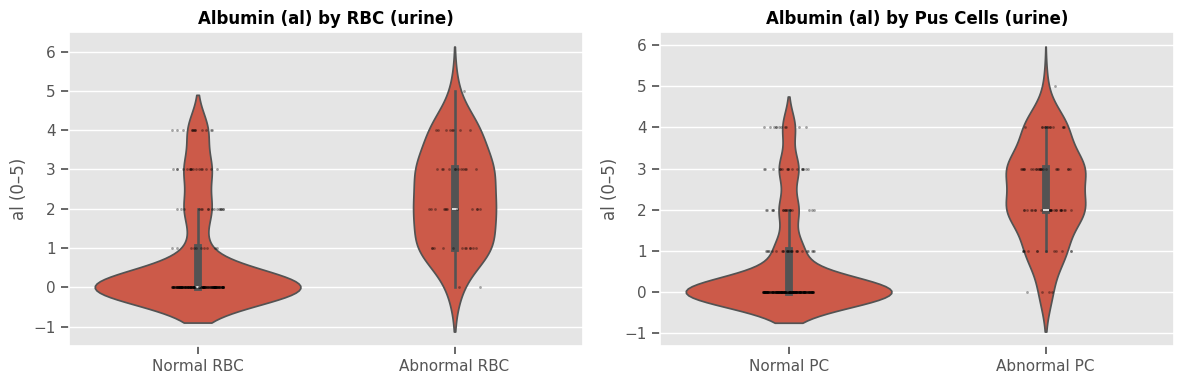

MWU al (Normal RBC vs Abnormal RBC): U=1651.0, p=1.361e-14, rank-biserial=0.645 | n(Normal RBC)=198, n(Abnormal RBC)=47
  median Normal RBC: 0 | Abnormal RBC: 2
MWU al (Normal PC vs Abnormal PC): U=2701.5, p=1.897e-26, rank-biserial=0.722 | n(Normal PC)=256, n(Abnormal PC)=76
  median Normal PC: 0 | Abnormal PC: 2


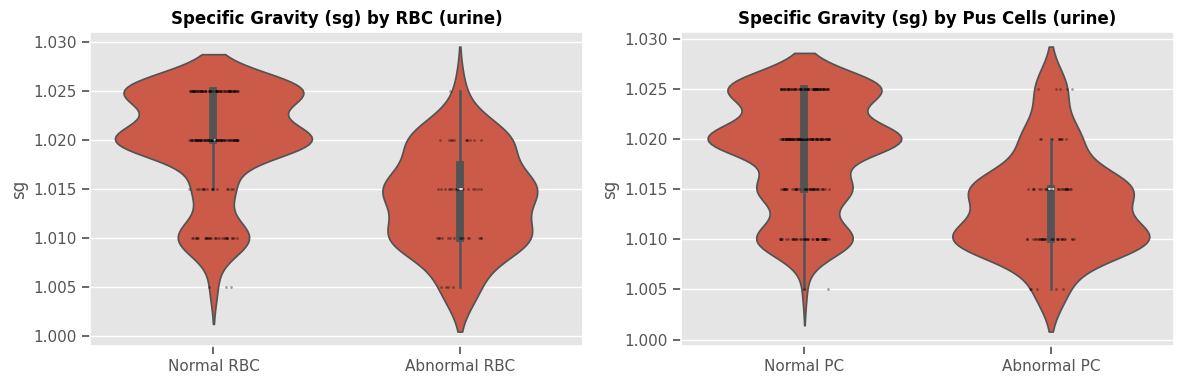

MWU sg (Normal RBC vs Abnormal RBC): U=7319.0, p=3.213e-10, rank-biserial=-0.565 | n(Normal RBC)=199, n(Abnormal RBC)=47
  median Normal RBC: 1.02 | Abnormal RBC: 1.01
MWU sg (Normal PC vs Abnormal PC): U=14400.5, p=1.747e-11, rank-biserial=-0.494 | n(Normal PC)=257, n(Abnormal PC)=75
  median Normal PC: 1.02 | Abnormal PC: 1.01


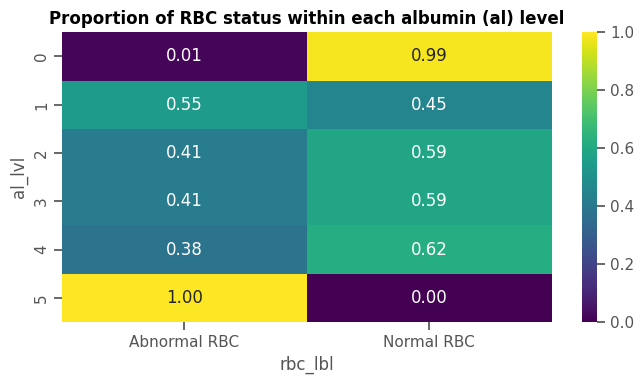

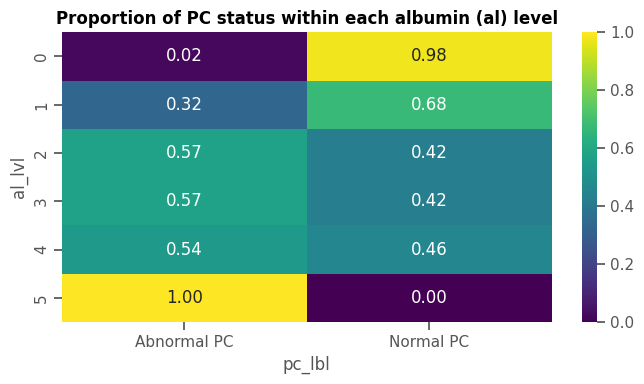


Chi-square rbc_lbl vs pc_lbl: chi2=40.946, dof=1, p=1.565e-10, Cramer's V=0.414


pc_lbl,Abnormal PC,Normal PC
rbc_lbl,,
Abnormal RBC,28,17
Normal RBC,30,164


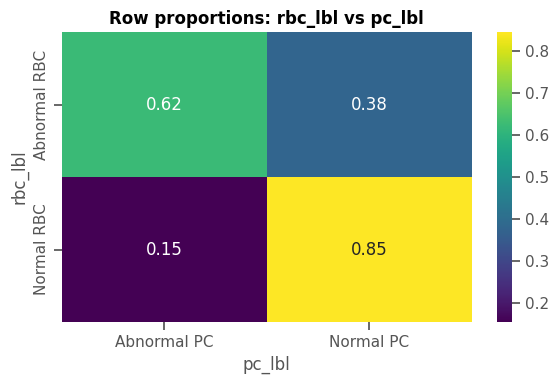


Chi-square pc_lbl vs pcc_lbl: chi2=84.227, dof=1, p=4.411e-20, Cramer's V=0.504


pcc_lbl,No PCC,PCC present
pc_lbl,,
Abnormal PC,43,33
Normal PC,248,8


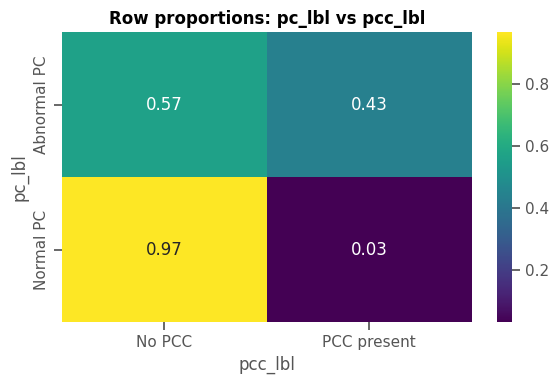


Chi-square pcc_lbl vs ba_lbl: chi2=26.072, dof=1, p=3.289e-07, Cramer's V=0.257


ba_lbl,Bacteria present,No bacteria
pcc_lbl,,
No PCC,12,342
PCC present,10,32


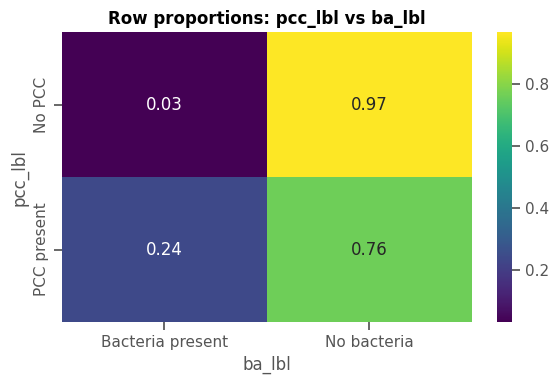


Chi-square pc_lbl vs ba_lbl: chi2=32.928, dof=1, p=9.565e-09, Cramer's V=0.315


ba_lbl,Bacteria present,No bacteria
pc_lbl,,
Abnormal PC,16,60
Normal PC,5,251


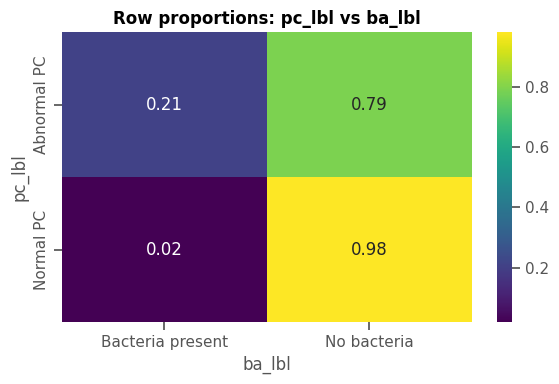


Spearman(sg, al): rho=-0.520, p=1.184e-25, n=351


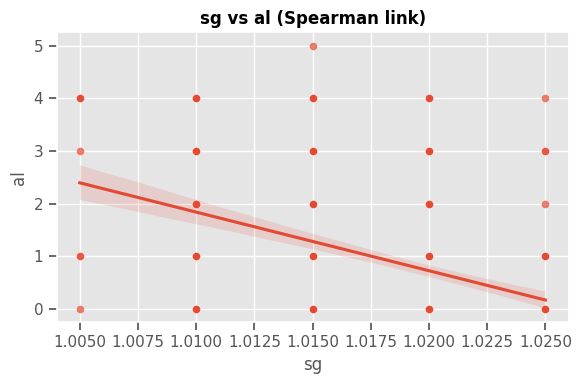


Group summaries (al by rbc_lbl):


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16048\2373478988.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(group_col)[val_col]


,n,median,q25,q75,iqr
rbc_lbl,,,,,
Normal RBC,198,0.0,0.0,1.0,1.0
Abnormal RBC,47,2.0,1.0,3.0,2.0



Group summaries (sg by rbc_lbl):


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16048\2373478988.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(group_col)[val_col]


,n,median,q25,q75,iqr
rbc_lbl,,,,,
Normal RBC,199,1.020,1.02,1.0250,0.0050
Abnormal RBC,47,1.015,1.01,1.0175,0.0075



Group summaries (al by pc_lbl):


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16048\2373478988.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(group_col)[val_col]


,n,median,q25,q75,iqr
pc_lbl,,,,,
Normal PC,256,0.0,0.0,1.0,1.0
Abnormal PC,76,2.0,2.0,3.0,1.0



Group summaries (sg by pc_lbl):


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16048\2373478988.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = tmp.groupby(group_col)[val_col]


,n,median,q25,q75,iqr
pc_lbl,,,,,
Normal PC,257,1.020,1.015,1.025,0.010
Abnormal PC,75,1.015,1.010,1.015,0.005


In [20]:

#Let's first define the urinalysis subset
u_cols = ["sg","al","rbc","pc","pcc","ba"]
df_u = df.copy() #a copy of the original dataset

#make sg/al numeric
df_u["sg"] = pd.to_numeric(df_u["sg"], errors="coerce")
df_u["al"] = pd.to_numeric(df_u["al"], errors="coerce")

#keep plausible ranges only
df_u.loc[~df_u["sg"].isin([1.005, 1.010, 1.015, 1.020, 1.025]), "sg"] = np.nan
df_u.loc[~df_u["al"].between(0, 5), "al"] = np.nan

#Labels for plots
df_u["rbc_lbl"] = df_u["rbc"].map({"normal":"Normal RBC", "abnormal":"Abnormal RBC"})
df_u["pc_lbl"]  = df_u["pc"].map({"normal":"Normal PC", "abnormal":"Abnormal PC"})
df_u["pcc_lbl"] = df_u["pcc"].map({"notpresent":"No PCC", "present":"PCC present"})
df_u["ba_lbl"]  = df_u["ba"].map({"notpresent":"No bacteria", "present":"Bacteria present"})

#Order of the sg and al
sg_order = [1.005, 1.010, 1.015, 1.020, 1.025]
al_order = [0, 1, 2, 3, 4, 5]

#statistics
def rank_biserial_from_u(u, n1, n2):
    # effect size: r_rb = 1 - 2U/(n1*n2)
    return 1 - (2*u)/(n1*n2)

def mwu_report(x, g, g0, g1, name):
    tmp = pd.DataFrame({"x": x, "g": g}).dropna()
    x0 = tmp.loc[tmp["g"] == g0, "x"]
    x1 = tmp.loc[tmp["g"] == g1, "x"]
    u, p = mannwhitneyu(x0, x1, alternative="two-sided")
    rrb = rank_biserial_from_u(u, len(x0), len(x1))
    print(f"MWU {name}: U={u:.1f}, p={p:.3e}, rank-biserial={rrb:.3f} | n({g0})={len(x0)}, n({g1})={len(x1)}")
    print(f"  median {g0}: {np.nanmedian(x0):.3g} | {g1}: {np.nanmedian(x1):.3g}")

def cramers_v_from_table(ct):
    # ct = pd.crosstab(...)
    chi2, p, dof, _ = chi2_contingency(ct)
    n = ct.to_numpy().sum()
    r, k = ct.shape
    v = np.sqrt(chi2 / (n * (min(r-1, k-1))))
    return chi2, p, dof, v

#Categorical distributions (rbc, pc, pcc, ba)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col, title in zip(
    axes,
    ["rbc_lbl","pc_lbl","pcc_lbl","ba_lbl"],
    ["Red Blood Cells (urine)", "Pus Cells (urine)", "Pus Cell Clumps", "Bacteria"]
):
    sns.countplot(data=df_u, x=col, hue=col, ax=ax, palette="viridis", dodge=False, legend=False)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

#Numeric ↔ categorical: ALBUMIN (al) vs RBC / PC
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.violinplot(data=df_u, x="rbc_lbl", y="al", order=["Normal RBC","Abnormal RBC"], ax=axes[0])
sns.stripplot(data=df_u, x="rbc_lbl", y="al", order=["Normal RBC","Abnormal RBC"], ax=axes[0],
              color="k", alpha=0.35, size=2)
axes[0].set_title("Albumin (al) by RBC (urine)", fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("al (0–5)")

sns.violinplot(data=df_u, x="pc_lbl", y="al", order=["Normal PC","Abnormal PC"], ax=axes[1])
sns.stripplot(data=df_u, x="pc_lbl", y="al", order=["Normal PC","Abnormal PC"], ax=axes[1],
              color="k", alpha=0.35, size=2)
axes[1].set_title("Albumin (al) by Pus Cells (urine)", fontweight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("al (0–5)")

plt.tight_layout()
plt.show()

#some more stats
mwu_report(df_u["al"], df_u["rbc_lbl"], "Normal RBC", "Abnormal RBC", "al (Normal RBC vs Abnormal RBC)")
mwu_report(df_u["al"], df_u["pc_lbl"],  "Normal PC",  "Abnormal PC",  "al (Normal PC vs Abnormal PC)")

#Numeric ↔ categorical: SPECIFIC GRAVITY (sg) vs RBC / PC
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.violinplot(data=df_u, x="rbc_lbl", y="sg", order=["Normal RBC","Abnormal RBC"], ax=axes[0])
sns.stripplot(data=df_u, x="rbc_lbl", y="sg", order=["Normal RBC","Abnormal RBC"], ax=axes[0],
              color="k", alpha=0.35, size=2)
axes[0].set_title("Specific Gravity (sg) by RBC (urine)", fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("sg")

sns.violinplot(data=df_u, x="pc_lbl", y="sg", order=["Normal PC","Abnormal PC"], ax=axes[1])
sns.stripplot(data=df_u, x="pc_lbl", y="sg", order=["Normal PC","Abnormal PC"], ax=axes[1],
              color="k", alpha=0.35, size=2)
axes[1].set_title("Specific Gravity (sg) by Pus Cells (urine)", fontweight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("sg")

plt.tight_layout()
plt.show()

#stats
mwu_report(df_u["sg"], df_u["rbc_lbl"], "Normal RBC", "Abnormal RBC", "sg (Normal RBC vs Abnormal RBC)")
mwu_report(df_u["sg"], df_u["pc_lbl"],  "Normal PC",  "Abnormal PC",  "sg (Normal PC vs Abnormal PC)")

# Heatmaps: proportions (easy “proof” visuals)
#   1) P(Abnormal RBC | al level)
#   2) P(Abnormal PC  | al level)
def prop_heatmap(df_in, level_col, target_col, target_positive, level_order=None, title=""):
    tmp = df_in[[level_col, target_col]].dropna()
    ct = pd.crosstab(tmp[level_col], tmp[target_col], normalize="index")
    if level_order is not None:
        ct = ct.reindex(level_order)
    plt.figure(figsize=(7,4))
    sns.heatmap(ct, annot=True, fmt=".2f", cmap="viridis")
    plt.title(title, fontweight="bold")
    plt.ylabel(level_col)
    plt.xlabel(target_col)
    plt.tight_layout()
    plt.show()
    return ct

#albumin levels → probability of abnormal findings
ct_rbc_al = prop_heatmap(
    df_u.assign(al_lvl=df_u["al"]),
    "al_lvl", "rbc_lbl", "Abnormal RBC",
    level_order=al_order,
    title="Proportion of RBC status within each albumin (al) level"
)

ct_pc_al = prop_heatmap(
    df_u.assign(al_lvl=df_u["al"]),
    "al_lvl", "pc_lbl", "Abnormal PC",
    level_order=al_order,
    title="Proportion of PC status within each albumin (al) level"
)

#Categorical ↔ categorical links (chi-square + Cramer's V)
#RBC vs PC, PC vs PCC, PCC vs Bacteria, PC vs Bacteria
pairs = [
    ("rbc_lbl","pc_lbl"),
    ("pc_lbl","pcc_lbl"),
    ("pcc_lbl","ba_lbl"),
    ("pc_lbl","ba_lbl"),
]

for a, b in pairs:
    tmp = df_u[[a,b]].dropna()
    ct = pd.crosstab(tmp[a], tmp[b])
    chi2, p, dof, v = cramers_v_from_table(ct)
    print(f"\nChi-square {a} vs {b}: chi2={chi2:.3f}, dof={dof}, p={p:.3e}, Cramer's V={v:.3f}")
    display(ct)

    # quick proportion heatmap
    plt.figure(figsize=(6,4))
    sns.heatmap(pd.crosstab(tmp[a], tmp[b], normalize="index"), annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"Row proportions: {a} vs {b}", fontweight="bold")
    plt.tight_layout()
    plt.show()



# sg <-> al (both ordinal-ish)
tmp = df_u[["sg","al"]].dropna()
rho, p = spearmanr(tmp["sg"], tmp["al"])
print(f"\nSpearman(sg, al): rho={rho:.3f}, p={p:.3e}, n={len(tmp)}")

plt.figure(figsize=(6,4))
sns.scatterplot(data=tmp, x="sg", y="al", alpha=0.7)
sns.regplot(data=tmp, x="sg", y="al", scatter=False)
plt.title("sg vs al (Spearman link)", fontweight="bold")
plt.tight_layout()
plt.show()

#Group summaries (median/IQR) for a nice table
def summary_median_iqr(df_in, group_col, val_col, order=None):
    tmp = df_in[[group_col, val_col]].dropna()
    if order is not None:
        tmp[group_col] = pd.Categorical(tmp[group_col], categories=order, ordered=True)
    g = tmp.groupby(group_col)[val_col]
    out = pd.DataFrame({
        "n": g.size(),
        "median": g.median(),
        "q25": g.quantile(0.25),
        "q75": g.quantile(0.75),
        "iqr": g.quantile(0.75) - g.quantile(0.25),
    })
    return out

print("\nGroup summaries (al by rbc_lbl):")
display(summary_median_iqr(df_u, "rbc_lbl", "al", order=["Normal RBC","Abnormal RBC"]))

print("\nGroup summaries (sg by rbc_lbl):")
display(summary_median_iqr(df_u, "rbc_lbl", "sg", order=["Normal RBC","Abnormal RBC"]))

print("\nGroup summaries (al by pc_lbl):")
display(summary_median_iqr(df_u, "pc_lbl", "al", order=["Normal PC","Abnormal PC"]))

print("\nGroup summaries (sg by pc_lbl):")
display(summary_median_iqr(df_u, "pc_lbl", "sg", order=["Normal PC","Abnormal PC"]))


**Conclusions for the Urinalysis Profile**:

- Specific gravity (sg) was lower when urine findings were abnormal. In particular, sg was significantly lower in samples with abnormal RBCs (median 1.02 → 1.01, MWU p = 3.213e-10) and with abnormal pus cells (median 1.02 → 1.01, MWU p = 1.747e-11), suggesting more dilute urine when abnormal urinalysis markers are present.

- Albumin (al) and specific gravity (sg) moved in opposite directions**. We observed a strong negative monotonic association between them (Spearman ρ = −0.520, p = 1.184e-25; n = 351), meaning that higher albumin levels tend to appear alongside lower sg.

- The categorical urinalysis markers also clustered together rather than behaving independently. Chi-square tests showed strong associations such as pc <-> pcc (V = 0.504, p = 4.411e-20) and rbc <-> pc (V = 0.414, p = 1.565e-10), with additional links involving bacteria (pc <-> bacteria: V = 0.315, p = 9.565e-09; pcc <-> bacteria: V = 0.257, p = 3.289e-07). Visually, the pc vs bacteria heatmap reinforced this: bacteria presence was much more frequent when pus cells were abnormal (~21% vs ~2%).

- Albumin (al) was clearly higher in the presence of abnormal urine findings. Albumin increased strongly when RBC was abnormal (median 0 → 2, MWU p = 1.361e-14, rank-biserial 0.645) and when pus cells were abnormal (median 0 → 2, MWU p = 1.897e-26, rank-biserial 0.722), supporting that albuminuria co-occurs with inflammatory/abnormal urinalysis patterns.


5)  **Kidney Function Markers Profile**

We finally focus on the core kidney function labs because they are the most directly tied to the CKD outcome. This profile includes blood urea (bu) and serum creatinine (sc) as primary waste-product markers, together with key electrolytes sodium (sod) and potassium (pot). Clinically, these variables are interdependent and changes in sc/bu are especially informative for kidney impairment.

n rows used: 400
status_lbl
CKD        250
Not CKD    150
Name: count, dtype: int64


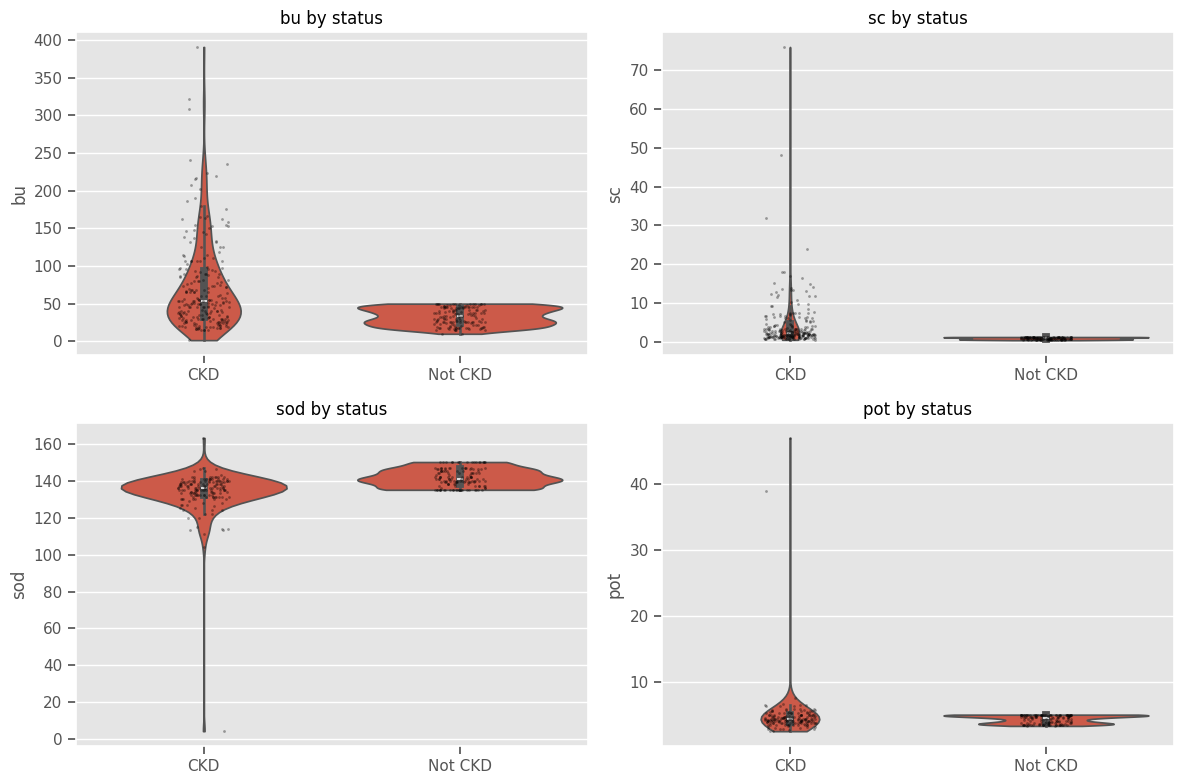


MWU tests (Not CKD vs CKD) + rank-biserial:
 bu: U=8486.5, p=1.869e-16, rbc=0.503 | median NotCKD=33 vs CKD=53
 sc: U=2668.5, p=6.578e-44, rbc=0.845 | median NotCKD=0.9 vs CKD=2.25
 sod: U=19583.0, p=1.499e-20, rbc=-0.608 | median NotCKD=141 vs CKD=136
 pot: U=11893.5, p=7.878e-01, rbc=0.018 | median NotCKD=4.5 vs CKD=4.3


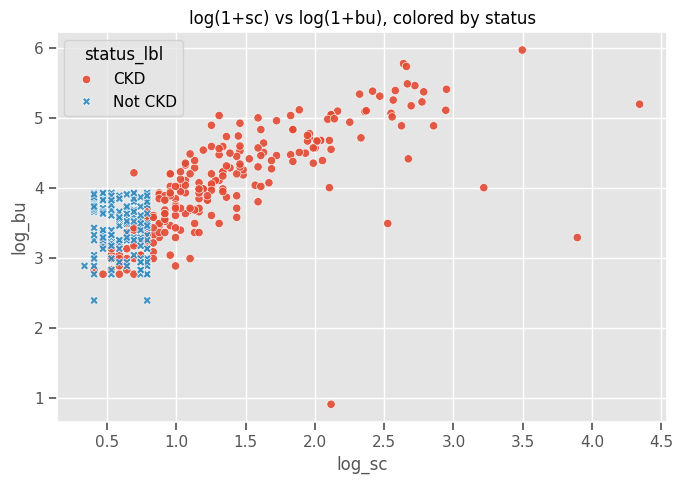


Spearman correlations:
overall Spearman(sc,bu): rho=0.703, p=6.540e-58, n=380
Not CKD Spearman(sc,bu): rho=-0.096, p=2.544e-01, n=144
CKD Spearman(sc,bu): rho=0.840, p=4.409e-64, n=236

Proportions by sc >= 5:
status_lbl       CKD   Not CKD
sc_ge_thr                     
0           0.553846  0.446154
1           1.000000  0.000000

Univariate ROC-AUC (best direction):
  feature       AUC   direction    n
1      sc  0.922675  higher→CKD  383
2     sod  0.803900   lower→CKD  313
0      bu  0.751333  higher→CKD  381
3     pot  0.508837  higher→CKD  312


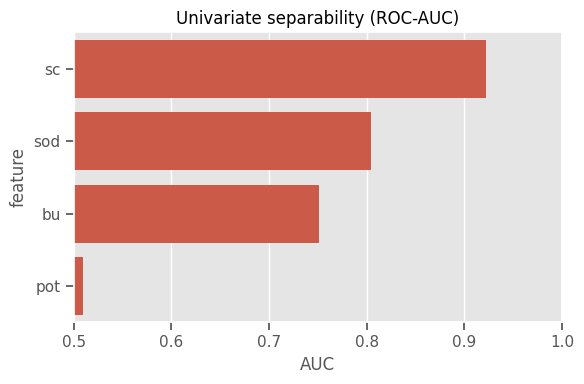

In [21]:

d = df.copy() #working with the copy of the original dataset 

#Standardize labels
d["status_lbl"] = d["status"].astype(str).str.strip().str.lower().map({
    "ckd": "CKD",
    "notckd": "Not CKD",
    "not ckd": "Not CKD"
})

#Numeric columns for this profile
kidney_cols = ["bu", "sc", "sod", "pot"]
for c in kidney_cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")

#Keep rows that have status + at least one marker
dk = d.dropna(subset=["status_lbl"])
#keep only CKD/Not CKD
dk = dk[dk["status_lbl"].isin(["CKD", "Not CKD"])]
print("n rows used:", dk.shape[0])
print(dk["status_lbl"].value_counts(dropna=False))

#Visuals: violins for each marker
plt.figure(figsize=(12, 8))
for i, c in enumerate(kidney_cols, 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(data=dk, x="status_lbl", y=c, inner="box", cut=0, ax=ax)
    sns.stripplot(data=dk, x="status_lbl", y=c, color="k", alpha=0.35, size=2, ax=ax)
    ax.set_title(f"{c} by status")
    ax.set_xlabel("")
plt.tight_layout()
plt.show()

# 2) MWU tests + rank-biserial effect size
def rank_biserial_from_u(U, n1, n2):
    # RBC = 1 - 2U/(n1*n2) when U is for group1 vs group2
    return 1 - (2 * U) / (n1 * n2)

print("\nMWU tests (Not CKD vs CKD) + rank-biserial:")
for c in kidney_cols:
    a = dk.loc[dk["status_lbl"]=="Not CKD", c].dropna()
    b = dk.loc[dk["status_lbl"]=="CKD", c].dropna()
    if len(a) < 5 or len(b) < 5:
        print(f" {c}: not enough data")
        continue

    U, p = mannwhitneyu(a, b, alternative="two-sided")
    rbc = rank_biserial_from_u(U, len(a), len(b))
    print(f" {c}: U={U:.1f}, p={p:.3e}, rbc={rbc:.3f} | median NotCKD={np.median(a):g} vs CKD={np.median(b):g}")

#Scatter proof: log(1+sc) vs log(1+bu)
tmp = dk.dropna(subset=["sc","bu"]).copy()
tmp["log_sc"] = np.log1p(tmp["sc"])
tmp["log_bu"] = np.log1p(tmp["bu"])

plt.figure(figsize=(7,5))
sns.scatterplot(data=tmp, x="log_sc", y="log_bu", hue="status_lbl", style="status_lbl", alpha=0.9)
plt.title("log(1+sc) vs log(1+bu), colored by status")
plt.tight_layout()
plt.show()

#Spearman correlations overall + per class
def spearman_block(df, x, y, label):
    rho, p = spearmanr(df[x], df[y])
    print(f"{label} Spearman({x},{y}): rho={rho:.3f}, p={p:.3e}, n={df.shape[0]}")

print("\nSpearman correlations:")
spearman_block(tmp, "sc", "bu", "overall")
spearman_block(tmp[tmp["status_lbl"]=="Not CKD"], "sc", "bu", "Not CKD")
spearman_block(tmp[tmp["status_lbl"]=="CKD"], "sc", "bu", "CKD")

#sc threshold table (e.g., sc >= 5)
thr = 5
t2 = dk.dropna(subset=["sc"]).copy()
t2["sc_ge_thr"] = (t2["sc"] >= thr).astype(int)

tab = pd.crosstab(t2["sc_ge_thr"], t2["status_lbl"], normalize="index")
print(f"\nProportions by sc >= {thr}:")
print(tab)


# Univariate ROC-AUC per marker
# y=1 for CKD, 0 for Not CKD
auc_df = []
for c in kidney_cols:
    sub = dk.dropna(subset=[c]).copy()
    y = (sub["status_lbl"]=="CKD").astype(int).values
    x = sub[c].values

    #AUC expects higher scores -> more CKD. For sodium, direction might be reversed.
    auc = roc_auc_score(y, x)

    #If auc < 0.5, flip direction (means higher value is protective / lower in CKD)
    auc_use = max(auc, 1-auc)
    direction = "higher→CKD" if auc >= 0.5 else "lower→CKD"
    auc_df.append((c, auc_use, direction, sub.shape[0]))

auc_df = pd.DataFrame(auc_df, columns=["feature","AUC","direction","n"]).sort_values("AUC", ascending=False)
print("\nUnivariate ROC-AUC (best direction):")
print(auc_df)

plt.figure(figsize=(6,4))
sns.barplot(data=auc_df, x="AUC", y="feature")
plt.title("Univariate separability (ROC-AUC)")
plt.xlim(0.5, 1.0)
plt.tight_layout()
plt.show()


**Conclusion for the Kidney profile**: 

In our data, serum creatinine (sc) is the best kidney marker: it is much higher in CKD than non-CKD (median 2.25 vs 0.9, MWU p ≈ 2e−46). Blood urea (bu) also separates the groups well (median 53 vs 33, p ≈ 1e−18), and sodium (sod) is lower in CKD (median 136 vs 141, p ≈ 2.5e−26). Potassium (pot) does not separate CKD from non-CKD here (p = 0.415) and has an extreme outlier, so it’s not a reliable marker in this dataset as-is.

Also, sc and bu strongly move together within CKD (Spearman ρ ≈ 0.83), but not in non-CKD (ρ ≈ −0.10), which fits the expected kidney impairment pattern.

**Overall EDA Conclusions**: 

Across the exploratory profiles, we identified several clinical dependencies that are useful to impute missing values in a more informed way than simple global averages or median approach. 
- The **anemia profile** shows a strong, consistent link between **hemo–pcv–rbcc** and the categorical label **ane**, so missing hemo/pcv/rbcc can be predicted using the others and/or the anemia status (and vice-versa). 

- The **diabetes–glucose profile** indicates that **bgr** increases with urine sugar **su**, and both align strongly with **dm**, supporting predictive imputation of bgr from (su, dm) or of dm/su from bgr. 

- The **hypertension–cardiovascular profile** connects higher **bp** to **htn**, and **htn** is strongly associated with **cad**, so bp/htn/cad can inform each other when values are missing. 

- The **urinalysis profile** reveals tightly coupled urine findings (rbc, pc, pcc, ba) and their association with higher **al** and lower **sg**, enabling joint imputation within this block. 

- The **kidney-function markers** (**sc**, **bu**, **sod**) separate CKD from Not-CKD strongly, meaning they can be used as high-signal predictors for missing renal markers and, when appropriate, as auxiliary predictors for other missing variables. 

We will impute by profile using multivariate methods (KNN/Iterative) wherever the relationships are strong.

### **Step 2.2: Fill Missing Values**



Encode the categorical columns

In [22]:
#Always work on a copy
data = df.copy(deep=True)

#Let's define the nominal Columns
binary_cols = ["rbc","pc","pcc","ba","htn","dm","cad","appet","pe","ane"]
ordinal_cols = ["sg","al","su"] # since we have levels

#Clean whitespace/casing for string categoricals
for c in binary_cols:
    data[c] = data[c].astype("string").str.strip().str.lower()

#Binary mappings
binary_maps = {
    "rbc": {"normal": 0, "abnormal": 1},
    "pc": {"normal": 0, "abnormal": 1},
    "pcc": {"notpresent": 0, "present": 1},
    "ba": {"notpresent": 0, "present": 1},
    "htn": {"no": 0, "yes": 1},
    "dm": {"no": 0, "yes": 1},
    "cad": {"no": 0, "yes": 1},
    "appet": {"good": 0, "poor": 1},
    "pe": {"no": 0, "yes": 1},
    "ane": {"no": 0, "yes": 1},
}

for c in binary_cols:
    data[c] = data[c].map(binary_maps[c])

#Ordinal encoding for sg, al, su
#Convert to numeric safely (will make invalid strings -> NaN)
data["sg"] = pd.to_numeric(data["sg"], errors="coerce")
data["al"] = pd.to_numeric(data["al"], errors="coerce")
data["su"] = pd.to_numeric(data["su"], errors="coerce")

# Explicit order for sg (5 levels)
sg_order = [1.005, 1.010, 1.015, 1.020, 1.025]
sg_map = {v: i for i, v in enumerate(sg_order)}  # 1.005->0 ... 1.025->4
data["sg"] = data["sg"].map(sg_map)

# al and su are already ordered 0..5
data.loc[~data["al"].between(0, 5), "al"] = np.nan
data.loc[~data["su"].between(0, 5), "su"] = np.nan

Create df_encoded (encoded + low-missing mode fill)

In [23]:
#df_encoded = encoded version of df 
df_encoded = data.copy(deep=True)

# MODE fill for low-missing binary columns
low_missing_cols = ["pcc","ba","htn","dm","cad","appet","pe","ane"]
for c in low_missing_cols:
    mode_val = df_encoded[c].mode(dropna=True).iloc[0]
    df_encoded[c] = df_encoded[c].fillna(mode_val)

print("Missing values in the encoded dataframe: ")
df_encoded.isna().sum()

Missing values in the encoded dataframe: 


age         9
bp         12
sg         47
al         46
su         49
rbc       152
pc         65
pcc         0
ba          0
bgr        44
bu         19
sc         17
sod        87
pot        88
hemo       52
pcv        71
wbcc      106
rbcc      131
htn         0
dm          0
cad         0
appet       0
pe          0
ane         0
status      0
dtype: int64

Now we don't have missing values for columns like "pcc","ba","htn","dm","cad","appet","pe","ane". 

In [24]:
# Build df_imputed and ensure no “shape mismatch” happens
df_imputed = df_encoded.copy(deep=True)


Impute the urinalysis profile together (rbc, pc, sg, al):

We found from the EDA that rbc and pc co-occur with pcc/ba, and that al and sg shift systematically with abnormal findings. That’s exactly our multivariate imputation preserves, it fills missing values in a way that stays consistent with the rest of the urinalysis pattern.

In [25]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Work on numeric matrix for the imputer
# (Everything here is already encoded to numbers, but we force numeric anyway)
for c in ["rbc","pc","pcc","ba","al","sg"]:
    df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

urine_cols = ["rbc","pc","pcc","ba","al","sg"]

imp_urine = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=400, min_samples_leaf=5, random_state=42, n_jobs=-1
    ),
    max_iter=25,
    random_state=42,
    initial_strategy="most_frequent"  # good for mostly-categorical blocks
)

df_imputed[urine_cols] = imp_urine.fit_transform(df_imputed[urine_cols])

# Snap back to valid categories
# rbc/pc/pcc/ba are binary 0/1
for c in ["rbc","pc","pcc","ba"]:
    df_imputed[c] = df_imputed[c].clip(0, 1).round().astype("Int64")

# al: 0..5, sg: 0..4 (our encoding)
df_imputed["al"] = df_imputed["al"].clip(0, 5).round().astype("Int64")
df_imputed["sg"] = df_imputed["sg"].clip(0, 4).round().astype("Int64")


Impute su using the glucose profile (bgr + dm):

su belongs to the glucose/diabetes profile. The clean way is to impute it using bgr and dm.

In [26]:
#Force numeric
df_imputed["bgr"] = pd.to_numeric(df_imputed["bgr"], errors="coerce")
df_imputed["dm"]  = pd.to_numeric(df_imputed["dm"],  errors="coerce")
df_imputed["su"]  = pd.to_numeric(df_imputed["su"],  errors="coerce")

glucose_cols = ["bgr", "dm", "su"]

imp_glucose = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=300, min_samples_leaf=4, random_state=42, n_jobs=-1
    ),
    max_iter=20,
    random_state=42,
    initial_strategy="median"
)

df_imputed[glucose_cols] = imp_glucose.fit_transform(df_imputed[glucose_cols])

# Snap back to valid categories
df_imputed["dm"] = df_imputed["dm"].clip(0, 1).round().astype("Int64")
df_imputed["su"] = df_imputed["su"].clip(0, 5).round().astype("Int64")


Verification: Now we should have 0 missing in the categorical columns

In [27]:
print("Verifying Missing Values for all the categorical columns:")
print(df_imputed[["rbc","pc","su","sg","al","pcc","ba","htn","dm","cad","appet","pe","ane"]].isna().sum())
#We should get 0 for all these columns


Verifying Missing Values for all the categorical columns:
rbc      0
pc       0
su       0
sg       0
al       0
pcc      0
ba       0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
dtype: int64


### Missing Values handling for the NUMERIC columns (based on imputation)

In [28]:
num_cols = ["age","bp","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc"]

# ensure numeric
for c in num_cols:
    df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

print("Missing counts (numeric):")
print(df_imputed[num_cols].isna().sum().sort_values(ascending=False))


Missing counts (numeric):
rbcc    131
wbcc    106
pot      88
sod      87
pcv      71
hemo     52
bu       19
sc       17
bp       12
age       9
bgr       0
dtype: int64


From the EDA, we observed that hemo,pcv and rbcc move together so applying multivariate imputation for these makes sense.Similarly, bu/sc/sod are informative and connected so imputing them together preserves realistic lab patterns.
Since hemo, pcv, rbcc, and wbcc are all CBC-type measurements, so they tend to carry shared structure. Imputing them together lets the model use the other blood markers to estimate missing wbcc. as for bp, it is directly informative for htn, so imputing bp with htn (and cad) is consistent with our profile logic.

In [29]:
#Make sure these columns are numeric
cols_needed = ["hemo","pcv","rbcc","wbcc","bp","htn","cad","bu","sc","sod","pot"]
for c in cols_needed:
    if c in df_imputed.columns:
        df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")

#clip extreme potassium outliers before imputing renal labs
if "pot" in df_imputed.columns and df_imputed["pot"].notna().any():
    lo, hi = df_imputed["pot"].quantile(0.01), df_imputed["pot"].quantile(0.99)
    df_imputed["pot"] = df_imputed["pot"].clip(lo, hi)

#BLOOD PROFILE: hemo + pcv + rbcc + wbcc (impute together)
blood_cols = [c for c in ["hemo","pcv","rbcc","wbcc"] if c in df_imputed.columns]
imp_blood = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=400, min_samples_leaf=5, random_state=42, n_jobs=-1
    ),
    max_iter=40,
    random_state=42,
    initial_strategy="median"
)
df_imputed.loc[:, blood_cols] = imp_blood.fit_transform(df_imputed[blood_cols])

#BP + HYPERTENSION PROFILE: bp using (bp, htn, cad)
bp_cols = [c for c in ["bp","htn","cad"] if c in df_imputed.columns]
imp_bp = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=300, min_samples_leaf=4, random_state=42, n_jobs=-1
    ),
    max_iter=40,
    random_state=42,
    initial_strategy="median"
)
df_imputed.loc[:, bp_cols] = imp_bp.fit_transform(df_imputed[bp_cols])

# snap htn/cad back to binary (since imputer outputs continuous)
for c in ["htn","cad"]:
    if c in df_imputed.columns:
        df_imputed[c] = df_imputed[c].clip(0, 1).round().astype("Int64")

#RENAL PROFILE (still worth doing together): bu/sc/sod/pot
renal_cols = [c for c in ["bu","sc","sod","pot"] if c in df_imputed.columns]
imp_renal = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=350, min_samples_leaf=4, random_state=42, n_jobs=-1
    ),
    max_iter=40,
    random_state=42,
    initial_strategy="median"
)
df_imputed.loc[:, renal_cols] = imp_renal.fit_transform(df_imputed[renal_cols])

#Age (small missing, not central): median fill
if "age" in df_imputed.columns:
    df_imputed["age"] = pd.to_numeric(df_imputed["age"], errors="coerce")
    df_imputed["age"] = df_imputed["age"].fillna(df_imputed["age"].median())

#Verify
check_cols = ["rbcc","wbcc","pot","sod","pcv","hemo","bu","sc","bp","age"]
check_cols = [c for c in check_cols if c in df_imputed.columns]

print("Missing AFTER (numeric):")
print(df_imputed[check_cols].isna().sum().sort_values(ascending=False))


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Missing AFTER (numeric):
rbcc    0
wbcc    0
pot     0
sod     0
pcv     0
hemo    0
bu      0
sc      0
bp      0
age     0
dtype: int64


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [30]:
#Let's check for missing values for our whole dataset --> Everything should be 0

df_imputed.isna().sum()

age       0
bp        0
sg        0
al        0
su        0
rbc       0
pc        0
pcc       0
ba        0
bgr       0
bu        0
sc        0
sod       0
pot       0
hemo      0
pcv       0
wbcc      0
rbcc      0
htn       0
dm        0
cad       0
appet     0
pe        0
ane       0
status    0
dtype: int64

### Step 3: Normalization and Encoding

From the previous analysis we noticed that our CKD dataset has 11 numeric + 13 nominal features, and some “categorical-looking” ones have multiple levels (e.g., sg has 5 values; al and su have 0-5). 

Since our dataset is quite diverse with 11 numeric and 13 nominal features, we will have to do the normalization/encoding part as follows:

- **Categorical columns**: This step has already been done in the Missing Data Analysis Part. In order to encode the categorical columns, we applied two methods:
    - **Binary Encoding**: When there are only two possible states e.g. yes/no, abnoraml/normal, present/notpresent, etc. we can map them to 0 and 1. 0 for baseline/normal/notpresent/no and 1 for abnormal/present/yes. 
    - **Ordinal Encoding**: When we have more levels and those levels are ordered we can make use of the ordinal encoding. Since order matters, we don’t want to treat each level as a completely separate “name.” So, we encode them as ranks (ordinal encoding) to preserve “higher means more”. In our case, 
        - sg: 1.005 < 1.010 < 1.015 < 1.020 < 1.025 
        - al: 0 < 1 < 2 < 3 < 4 < 5 
        - su: 0 < 1 < 2 < 3 < 4 < 5 

- **Numeric columns**: we have to scale/transform the values using techniques like min–max, z-score, robust, log, etc.  --> (NORMALIZATION)

### Categorical Columns 

In [31]:
# Quick check
print(df_imputed[binary_cols + ordinal_cols].head(10))

   rbc  pc  pcc  ba  htn  dm  cad  appet   pe  ane  sg  al  su
0    1   0    0   0    1   1    0    0.0  0.0  0.0   3   1   0
1    0   0    0   0    0   0    0    0.0  0.0  0.0   3   4   0
2    0   0    0   0    0   1    0    1.0  0.0  1.0   1   2   3
3    0   1    1   0    1   0    0    1.0  1.0  1.0   0   4   0
4    0   0    0   0    0   0    0    0.0  0.0  0.0   1   2   0
5    0   0    0   0    1   1    0    0.0  1.0  0.0   2   3   0
6    0   0    0   0    0   0    0    0.0  0.0  0.0   1   0   0
7    0   1    0   0    0   1    0    0.0  1.0  0.0   2   2   4
8    0   1    1   0    1   1    0    0.0  0.0  1.0   2   3   0
9    1   1    1   0    1   1    0    1.0  0.0  1.0   3   2   0


### Numeric Columns 

Numeric columns are easy to scale. We have true continuous numeric columns in our dataset e.g. age, bp, bgr, bu, sc, sod, pot, hemo, pcv, wbcc, rbcc, we can apply the following methods to normalise them.

- **Standardization (z-score)**: mean 0, std 1 (StandardScaler). This method is especially good for linear models, SVM, kNN, neural nets.

- **Min–max scaling**: maps to [0,1] (MinMaxScaler). This method is good if we explicitly want bounded features.

- **Robust scaling**: uses median/IQR (RobustScaler). This method comes in handy when we have heavy outliers (we do: sc, bu, bgr, wbcc look very skewed).

- **Log / power transforms**: reduce right-skew (e.g., log1p, Yeo–Johnson). It is often helpful for sc, bu, bgr, wbcc.

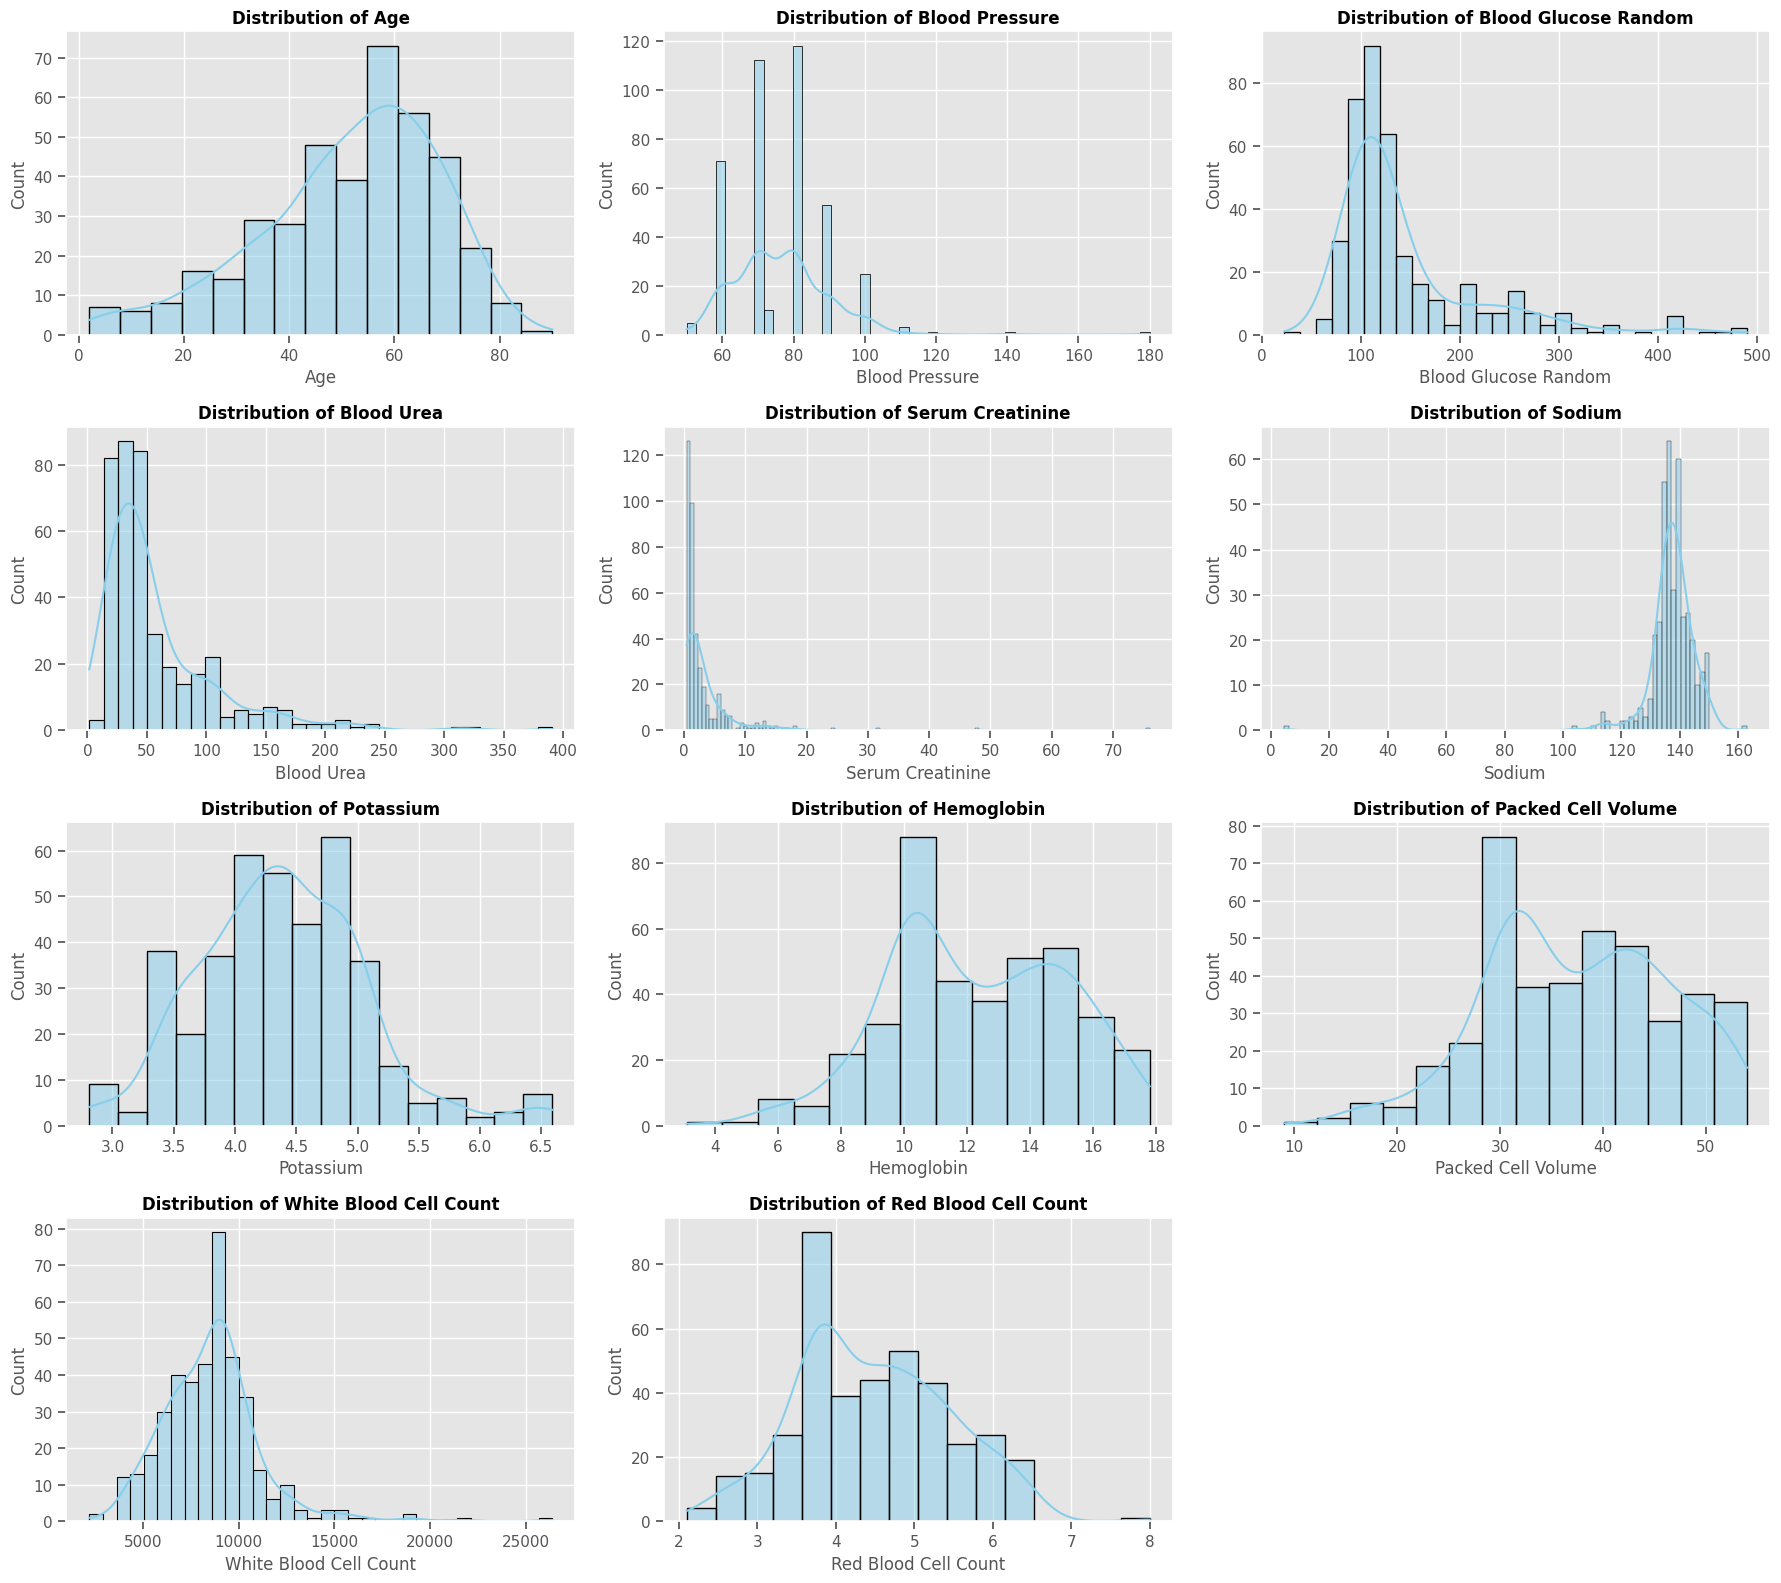

In [32]:
#Univariate Analysis 
# Dictionary mapping column names to full names based on dataset documentation
numeric_cols_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count'
}

# Setup the plotting grid (4 rows x 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (col, full_name) in enumerate(numeric_cols_mapping.items()):
    # Plot histogram with KDE
    sns.histplot(df_imputed[col], kde=True, ax=axes[i], color='skyblue', edgecolor='black')

    # Set titles and labels using the full name
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(len(numeric_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on the histograms:

- **age**: left-skewed (most values are higher, with a longer tail toward younger ages)
- **bp (blood pressure)**: right-skewed (tail to higher BP; also looks “spiky” because BP is often recorded in rounded steps)
- **bgr (blood glucose random)**: right-skewed (long tail to high glucose)
- **bu (blood urea)**: right-skewed (long tail to high urea)
- **sc (serum creatinine)**: strongly right-skewed (many low values + extreme high outliers)
- **sod (sodium)**: slightly left-skewed (cluster around ~135-145 with a longer tail to low sodium). We have to ignore the extreme 4.5 possible outlier.
- **pot (potassium)**: slighly right-skewed (mostly ~3-6 with a very large right-side outlier)
- **hemo (hemoglobin)**: left-skewed (peak around ~13-16 with a longer tail toward low Hb)
- **pcv (packed cell volume)**: left-skewed (more mass at higher PCV with a tail down to low values)
- **wbcc (WBC count)**: right-skewed (tail to very high counts)
- **rbcc (RBC count)**: approximately symmetric, maybe slightly right-skewed (looks close to bell-shaped, with a small right tail/outlier)

We have 6 features that are right-skewed, 4 left-skewed and 1 is symmetric out of the 11 numeric features. So, we need to reduce the skew first and then scale these numeric columns. For this task we have decided to apply the powerTransformer method Yeo–Johnson because it handles right and left-skew in one consistent step plus RobustScaler for scaling because we have strong outliers for columns like sc, pot, and the sod. 

In [33]:
#Start from the fully imputed dataset
df_norm = df_imputed.copy(deep=True)

#Only continuous numeric features get transformed/scaled
num_cols_to_transform = ["age","bp","bgr","bu","sc","sod","pot","hemo","pcv","wbcc","rbcc"]

#ensure numeric in df_norm (not df_imputed)
for c in num_cols_to_transform:
    df_norm[c] = pd.to_numeric(df_norm[c], errors="coerce")

# Handle obvious outliers BEFORE transforming (in df_norm)
df_norm.loc[df_norm["sod"] < 100, "sod"] = np.nan
df_norm["sod"] = df_norm["sod"].fillna(df_norm["sod"].median())

pot_lo, pot_hi = df_norm["pot"].quantile(0.01), df_norm["pot"].quantile(0.99)
df_norm["pot"] = df_norm["pot"].clip(pot_lo, pot_hi)

#Power transform (Yeo–Johnson) + robust scaling
X_num = df_norm[num_cols_to_transform].to_numpy()

pt = PowerTransformer(method="yeo-johnson", standardize=False)
X_pt = pt.fit_transform(X_num)

rs = RobustScaler()
X_scaled = rs.fit_transform(X_pt)

#Put scaled values back into df_norm
df_norm.loc[:, num_cols_to_transform] = X_scaled

#sanity check
print("df_imputed unchanged missing:", df_imputed[num_cols_to_transform].isna().sum().sum())
print("df_norm missing:", df_norm[num_cols_to_transform].isna().sum().sum())


df_imputed unchanged missing: 0
df_norm missing: 0


# Later for train/test splitting, we should fit pt and rs on train only and transform test with the same fitted objects.

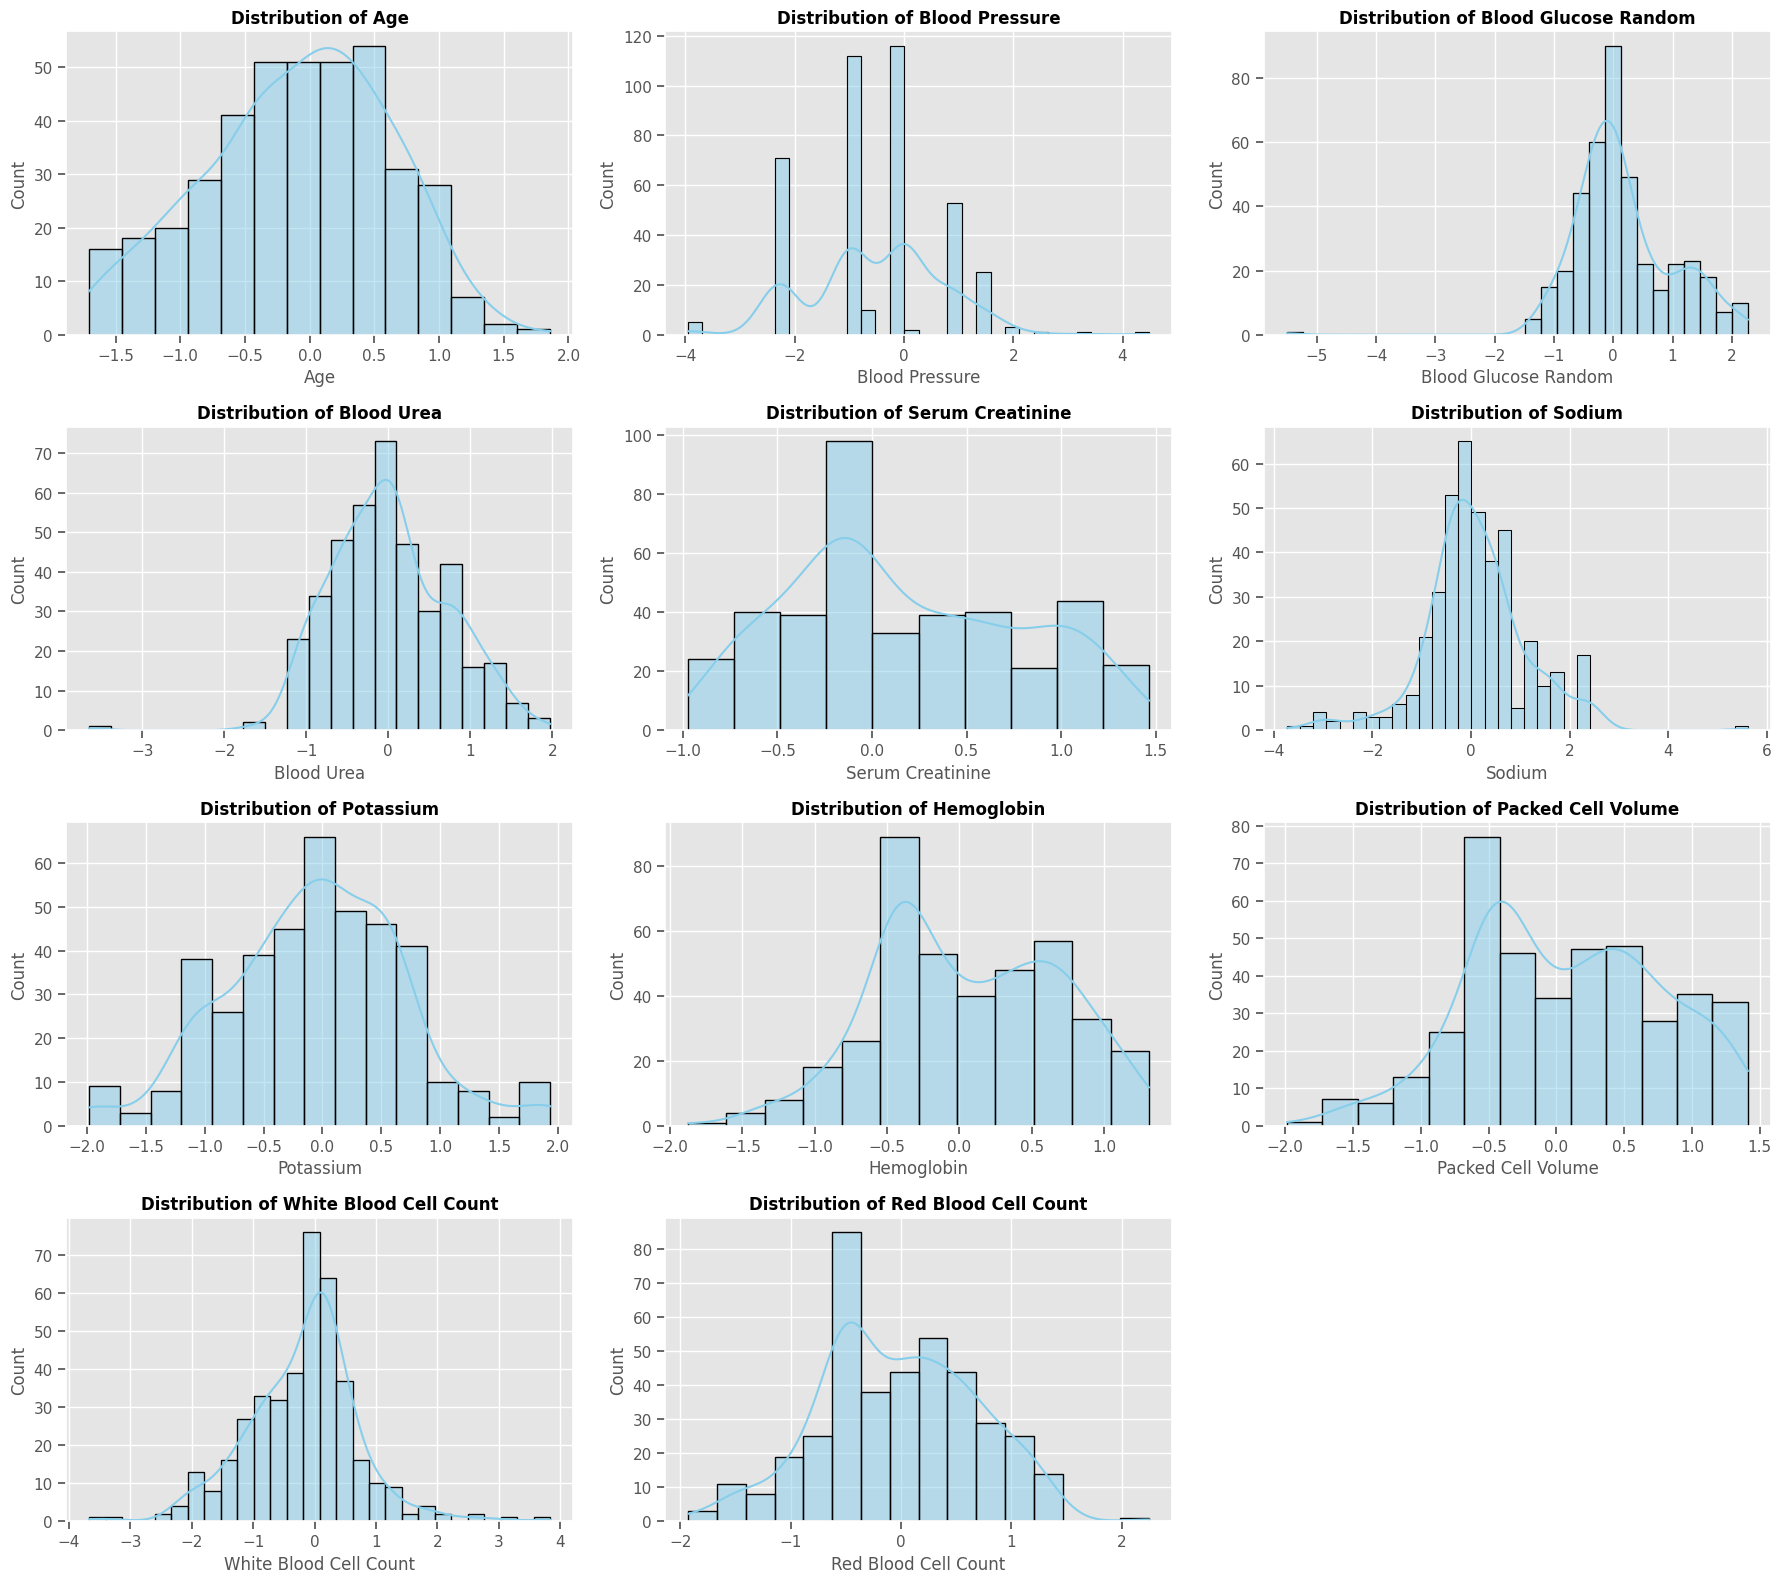

In [35]:
#Univariate Analysis 
# Dictionary mapping column names to full names based on dataset documentation
numeric_cols_mapping = {
    'age': 'Age',
    'bp': 'Blood Pressure',
    'bgr': 'Blood Glucose Random',
    'bu': 'Blood Urea',
    'sc': 'Serum Creatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'Packed Cell Volume',
    'wbcc': 'White Blood Cell Count',
    'rbcc': 'Red Blood Cell Count'
}

# Setup the plotting grid (4 rows x 3 columns)
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (col, full_name) in enumerate(numeric_cols_mapping.items()):
    # Plot histogram with KDE
    sns.histplot(df_norm[col], kde=True, ax=axes[i], color='skyblue', edgecolor='black')

    # Set titles and labels using the full name
    axes[i].set_title(f'Distribution of {full_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(full_name)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(len(numeric_cols_mapping), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Step 4: Feature Engineering 

In [36]:
import numpy as np
import pandas as pd

# 1) Choose the dataset for clustering
work = df_norm.copy()

# 2) Separate label for visualization only
y_status = work["status"].astype("string").str.strip().str.lower()

# 3) Features only (DO NOT include status)
X = work.drop(columns=["status"]).copy()

# 4) Safety checks
print("Any missing in X?", X.isna().sum().sum())
print("X shape:", X.shape)
print("Status counts:\n", y_status.value_counts(dropna=False))


Any missing in X? 0
X shape: (400, 24)
Status counts:
 status
ckd       250
notckd    150
Name: count, dtype: Int64


### 4.1 Unsupervised Learning 

**PCA:**
PCA helps US see whether the data naturally separates, and later we’ll overlay clusters on the same PCA space.

Explained variance ratio: [0.33427527 0.11582278]
Total explained (PC1+PC2): 0.45009805205326253


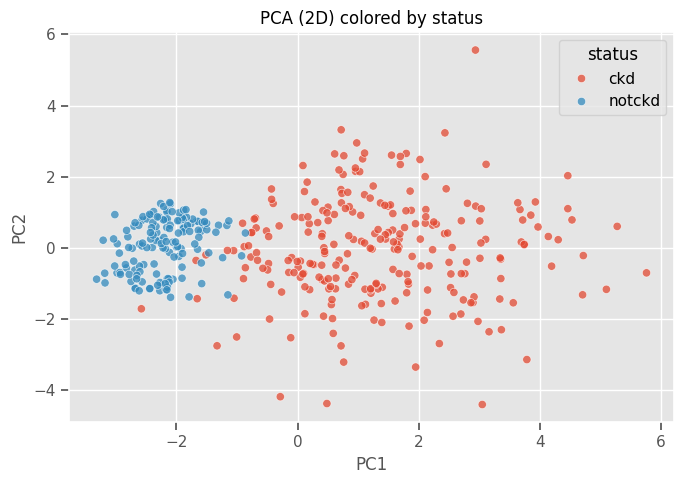

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X)

pca_df = pd.DataFrame(Z, columns=["PC1", "PC2"])
pca_df["status"] = y_status.values

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained (PC1+PC2):", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="status", alpha=0.75)
plt.title("PCA (2D) colored by status")
plt.tight_layout()
plt.show()


K-means

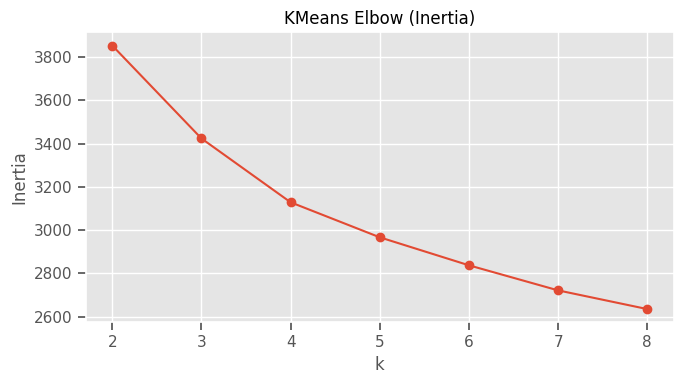

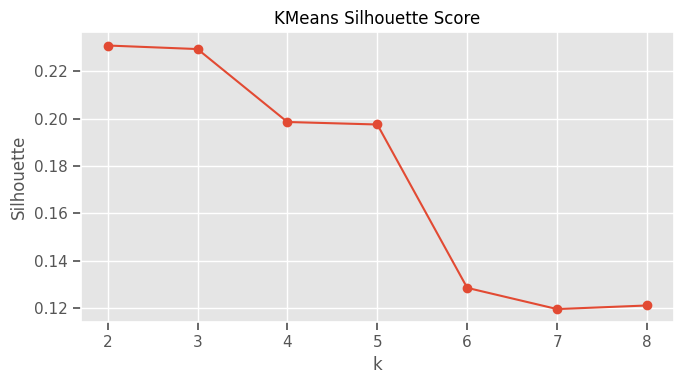

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = range(2, 9)
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))

# Plot elbow + silhouette
plt.figure(figsize=(7,4))
plt.plot(list(ks), inertias, marker="o")
plt.title("KMeans Elbow (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(list(ks), silhouettes, marker="o")
plt.title("KMeans Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()


Pick k as The best silhouette peak or an elbow point if silhouette is flat

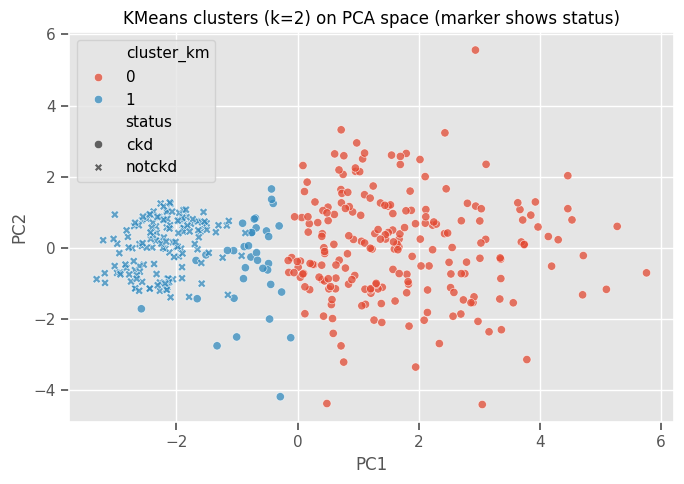

status           ckd    notckd
cluster_km                    
0           1.000000  0.000000
1           0.193548  0.806452


In [40]:
k = 2
km = KMeans(n_clusters=k, random_state=42, n_init=20)
cluster_km = km.fit_predict(X)

pca_df["cluster_km"] = cluster_km

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster_km", style="status", alpha=0.75)
plt.title(f"KMeans clusters (k={k}) on PCA space (marker shows status)")
plt.tight_layout()
plt.show()

# Cluster vs status table
ct = pd.crosstab(pca_df["cluster_km"], pca_df["status"], normalize="index")
print(ct)


Hierarchical 

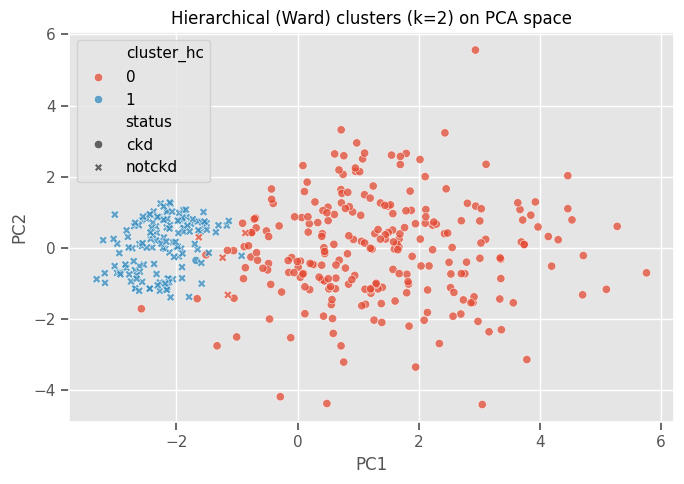

status           ckd    notckd
cluster_hc                    
0           0.984190  0.015810
1           0.006803  0.993197


In [41]:
from sklearn.cluster import AgglomerativeClustering

k = 2
hc = AgglomerativeClustering(n_clusters=k, linkage="ward")
cluster_hc = hc.fit_predict(X)

pca_df["cluster_hc"] = cluster_hc

plt.figure(figsize=(7,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster_hc", style="status", alpha=0.75)
plt.title(f"Hierarchical (Ward) clusters (k={k}) on PCA space")
plt.tight_layout()
plt.show()

ct_h = pd.crosstab(pca_df["cluster_hc"], pca_df["status"], normalize="index")
print(ct_h)


In [42]:
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import f1_score
from sklearn.feature_selection import f_classif

# Features (NO status)
work = df_norm.copy()
y = work["status"].astype("string").str.strip().str.lower()
X = work.drop(columns=["status"]).copy()

# Safety: no missing values
assert X.isna().sum().sum() == 0, "X still has missing values. Fix imputation first."


In [43]:
def clusters_to_status(labels, y_true):
    """Map each cluster to the most frequent status inside it."""
    y_pred = pd.Series(index=y_true.index, dtype="string")
    for cl in np.unique(labels):
        mask = labels == cl
        majority = y_true[mask].value_counts().idxmax()
        y_pred.loc[mask] = majority
    return y_pred

def run_hierarchical(linkage, X, y, k=2):
    # Ward only works with euclidean distance
    if linkage == "ward":
        model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    else:
        # Newer sklearn uses `metric=...`, older uses `affinity=...`
        try:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric="euclidean")
        except TypeError:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage, affinity="euclidean")

    labels = model.fit_predict(X)

    # F1-score vs status (extrinsic evaluation)
    y_pred = clusters_to_status(labels, y)
    f1 = f1_score(y, y_pred, average="weighted")  # weighted handles class imbalance

    # Per-feature ANOVA F-score vs cluster labels (which features define the clusters)
    F, p = f_classif(X, labels)
    feat_stats = pd.DataFrame({"feature": X.columns, "F": F, "p_value": p}).sort_values("F", ascending=False)

    return labels, f1, feat_stats


In [44]:
linkages = ["ward", "complete", "average", "single"]

f1_by_linkage = {}
fstats_by_linkage = {}

for lk in linkages:
    labels, f1, feat_stats = run_hierarchical(lk, X, y, k=2)
    f1_by_linkage[lk] = f1
    fstats_by_linkage[lk] = feat_stats

print("F1-score (clusters mapped to status):")
print(pd.Series(f1_by_linkage).sort_values(ascending=False))


F1-score (clusters mapped to status):
ward        0.987474
complete    0.480769
average     0.480769
single      0.480769
dtype: float64


**Linkage comparison (F1 vs status)**

With Ward linkage, the clusters line up extremely well with status (F1≈0.99). That means Ward is basically splitting the data into two groups that almost match CKD vs not-CKD.
In contrast, complete/average/single give F1≈0.48, which is close to not useful or near-random alignment with status in this dataset.

In [45]:
F_table = pd.DataFrame({"feature": X.columns})

for lk in linkages:
    tmp = fstats_by_linkage[lk][["feature", "F"]].rename(columns={"F": f"F_{lk}"})
    F_table = F_table.merge(tmp, on="feature", how="left")

# Sort by the best linkage's F-score (or by average across linkages)
F_table["F_mean"] = F_table[[f"F_{lk}" for lk in linkages]].mean(axis=1)
F_table = F_table.sort_values("F_mean", ascending=False)

print("\nPer-feature ANOVA F-scores (higher = feature separates clusters more):")
print(F_table.head(15))



Per-feature ANOVA F-scores (higher = feature separates clusters more):
   feature      F_ward  F_complete  F_average   F_single      F_mean
14    hemo  578.925093    0.073868   0.073868   0.073868  144.786675
15     pcv  514.782556    0.131721   0.131721   0.131721  128.794430
17    rbcc  387.262391    0.080112   0.080112   0.080112   96.875682
11      sc  321.575346    2.277457   2.277457   2.277457   82.101929
2       sg  301.705848    0.235777   0.235777   0.235777   75.603294
9      bgr   65.360195   51.821806  51.821806  51.821806   55.206403
18     htn  202.839198    0.580417   0.580417   0.580417   51.145112
19      dm  172.744009    0.520286   0.520286   0.520286   43.576217
10      bu   81.233907   28.502406  28.502406  28.502406   41.685281
3       al  152.115414    0.005231   0.005231   0.005231   38.032777
12     sod  130.327129    1.448517   1.448517   1.448517   33.668170
6       pc   65.192400    0.241776   0.241776   0.241776   16.479432
21   appet   64.815538    0.257

For Ward, the strongest separating features are clearly hemo, pcv, rbcc with very large F-scores so our  blood/anemia profile is a major separator. Features like sc and sg also strongly separate clusters which corresponds to our kidney function marker (sc) + urinalysis marker (sg). Then bgr, htn, dm, bu, sod, al contribute as secondary separators.

For the other linkages,F-scores are mostly tiny for many variables, which matches their poor F1, those linkage methods are not forming clusters that reflect the structure tied to status.

**Other methods we can try**:


- Logistic regression (clean + interpretable coefficients)

In [46]:
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering

# 1) Features + status (status is only for interpretation later)
y_status = df_norm["status"].astype("string").str.strip().str.lower()

# 2) X = all features except status
X = df_norm.drop(columns=["status"]).copy()

# 3) Safety check: clustering needs no missing values
print("Total missing in X:", X.isna().sum().sum())

# 4) Ward hierarchical clustering (k=2, since it matched status best in your results)
ward = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels_ward = ward.fit_predict(X)

print("Cluster sizes:", pd.Series(labels_ward).value_counts().to_dict())
print("Status counts:", y_status.value_counts().to_dict())


Total missing in X: 0
Cluster sizes: {0: 253, 1: 147}
Status counts: {'ckd': 250, 'notckd': 150}


1) Cluster medians + differences 

In [ ]:
X_tmp = X.copy()
X_tmp["cluster"] = labels_ward

cluster_medians = X_tmp.groupby("cluster").median(numeric_only=True)
diff = (cluster_medians.loc[1] - cluster_medians.loc[0]).sort_values(key=np.abs, ascending=False) # type: ignore

print("Top 15 median differences (Cluster 1 - Cluster 0):")
print(diff.head(15))


Top 15 median differences (Cluster 1 - Cluster 0):
pcv     1.165911
rbcc    1.067702
hemo    1.064237
bp          -1.0
htn         -1.0
sg           1.0
al          -1.0
dm          -1.0
sod     0.842867
sc     -0.805339
wbcc   -0.546397
age    -0.540973
bu     -0.522856
bgr     -0.43125
pot      0.18363
dtype: Float64


2) Effect size per feature (Cohen’s d):how big the separation is for each feature

In [48]:
def cohens_d(a, b):
    a, b = np.asarray(a), np.asarray(b)
    a, b = a[~np.isnan(a)], b[~np.isnan(b)]
    na, nb = len(a), len(b)
    sa, sb = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na+nb-2))
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan

effects = []
for col in X.columns:
    g0 = X.loc[labels_ward == 0, col]
    g1 = X.loc[labels_ward == 1, col]
    d = cohens_d(g0, g1)
    effects.append((col, d, abs(d)))

eff_df = pd.DataFrame(effects, columns=["feature", "cohens_d", "abs_d"]).sort_values("abs_d", ascending=False)
print("Top 15 by |Cohen's d|:")
print(eff_df.head(15))


Top 15 by |Cohen's d|:
   feature  cohens_d     abs_d
14    hemo -2.495297  2.495297
15     pcv -2.353006  2.353006
17    rbcc -2.040862  2.040862
11      sc  1.859741  1.859741
2       sg -1.801370  1.801370
18     htn  1.477022  1.477022
19      dm  1.363052  1.363052
3       al  1.279080  1.279080
12     sod -1.183937  1.183937
10      bu  0.934716  0.934716
9      bgr  0.838432  0.838432
6       pc  0.837355  0.837355
21   appet  0.834931  0.834931
22      pe  0.821867  0.821867
23     ane  0.699324  0.699324


In [49]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, labels_ward, random_state=42)
mi_df = pd.DataFrame({"feature": X.columns, "MI": mi}).sort_values("MI", ascending=False)

print("Top 15 by Mutual Information:")
print(mi_df.head(15))


Top 15 by Mutual Information:
   feature        MI
14    hemo  0.438167
15     pcv  0.437963
17    rbcc  0.400759
11      sc  0.362794
2       sg  0.315531
3       al  0.235163
12     sod  0.225509
18     htn  0.219892
13     pot  0.214856
19      dm  0.198225
10      bu  0.186568
1       bp  0.177562
9      bgr  0.175397
21   appet  0.135997
6       pc  0.116493


Model based

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X, labels_ward)

rf_imp = pd.DataFrame({"feature": X.columns, "importance": rf.feature_importances_}) \
            .sort_values("importance", ascending=False)

print("Top 15 by RandomForest importance:")
print(rf_imp.head(15))


Top 15 by RandomForest importance:
   feature  importance
14    hemo    0.177844
15     pcv    0.172212
17    rbcc    0.128981
11      sc    0.121032
2       sg    0.113967
3       al    0.060343
18     htn    0.048229
19      dm    0.034483
10      bu    0.031501
9      bgr    0.029690
12     sod    0.021812
1       bp    0.010605
13     pot    0.008429
4       su    0.008153
0      age    0.007963


In [51]:
ct = pd.crosstab(labels_ward, y_status, normalize="index")
print("Cluster composition by status (row %):")
print(ct)


Cluster composition by status (row %):
status       ckd    notckd
row_0                     
0       0.984190  0.015810
1       0.006803  0.993197


In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)
lr.fit(X, labels_ward)

coef = pd.Series(lr.coef_[0], index=X.columns)
coef_df = pd.DataFrame({"feature": X.columns, "coef": coef.values, "abs_coef": coef.abs().values})
coef_df.sort_values("abs_coef", ascending=False).head(15)


,feature,coef,abs_coef
2,sg,1.796482,1.796482
17,rbcc,1.551772,1.551772
11,sc,-1.514218,1.514218
3,al,-1.322926,1.322926
14,hemo,1.316542,1.316542
19,dm,-1.276967,1.276967
15,pcv,1.246071,1.246071
18,htn,-0.782582,0.782582
12,sod,0.754539,0.754539
4,su,-0.703769,0.703769
